# **TP de Data visualisation (par Seaborn)**
###réalisé par : DRIEF NISRINE  et ALAE BOUTARHAT

# Analyse des Données sur le Changement Climatique: Température de Surface de la Terre

###Introduction
Objectifs
Analyser les tendances climatiques historiques dans les grandes villes mondiales en se focalisant sur:


*   L'évolution temporelle des températures

*   Les variations saisonnières
*   Les différences géographiques



Source des données
Jeu de données "GlobalLandTemperaturesByMajorCity.csv" de Berkeley Earth disponible sur Kaggle.

**Préparation des Données**

Description Statistique Initiale

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Chargement des données
df = pd.read_csv('/content/drive/MyDrive/DATA VIZ/GlobalLandTemperaturesByMajorCity.csv')

# Affichage des informations de base
print(f"Nombre d'enregistrements: {len(df)}")
print(f"Nombre de colonnes: {len(df.columns)}")
print("\nVariables catégorielles:", df.select_dtypes(include=['object']).columns.tolist())
print("Variables numériques:", df.select_dtypes(include=['float64']).columns.tolist())
print("\nValeurs manquantes:")
print(df.isnull().sum())

Nombre d'enregistrements: 239177
Nombre de colonnes: 7

Variables catégorielles: ['dt', 'City', 'Country', 'Latitude', 'Longitude']
Variables numériques: ['AverageTemperature', 'AverageTemperatureUncertainty']

Valeurs manquantes:
dt                                   0
AverageTemperature               11002
AverageTemperatureUncertainty    11002
City                                 0
Country                              0
Latitude                             0
Longitude                            0
dtype: int64


In [ ]:
print(f"Nombre de lignes: {df.shape[0]}")
print(f"Nombre de colonnes: {df.shape[1]}")
print("\nInformations sur le dataframe:")
print(df.info())
print("\nStatistiques descriptives:")
# Remove the unsupported argument datetime_is_numeric
df.describe(include='all')

Nombre de lignes: 239177
Nombre de colonnes: 7

Informations sur le dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239177 entries, 0 to 239176
Data columns (total 7 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             239177 non-null  object 
 1   AverageTemperature             228175 non-null  float64
 2   AverageTemperatureUncertainty  228175 non-null  float64
 3   City                           239177 non-null  object 
 4   Country                        239177 non-null  object 
 5   Latitude                       239177 non-null  object 
 6   Longitude                      239177 non-null  object 
dtypes: float64(2), object(5)
memory usage: 12.8+ MB
None

Statistiques descriptives:


dt  AverageTemperature  AverageTemperatureUncertainty  \
count       239177       228175.000000                  228175.000000   
unique        3239                 NaN                            NaN   
top     2013-09-01                 NaN                            NaN   
freq           100                 NaN                            NaN   
mean           NaN           18.125969                       0.969343   
std            NaN           10.024800                       0.979644   
min            NaN          -26.772000                       0.040000   
25%            NaN           12.710000                       0.340000   
50%            NaN           20.428000                       0.592000   
75%            NaN           25.918000                       1.320000   
max            NaN           38.283000                      14.037000   

           City Country Latitude Longitude  
count    239177  239177   239177    239177  
unique      100      49       49        93  
top     Chicago   India   31.35N    31.38E  
freq       3239   36582    13875      6801  
mean        NaN     NaN      NaN       NaN  
std         NaN     NaN      NaN       NaN  
min         NaN     NaN      NaN       NaN  
25%         NaN     NaN      NaN       NaN  
50%         NaN     NaN      NaN       NaN  
75%         NaN     NaN      NaN       NaN  
max         NaN     NaN      NaN       NaN

**Nettoyage des Données**

In [ ]:
# Remplissage par la moyenne mensuelle par ville
df['dt'] = pd.to_datetime(df['dt'])
df['Month'] = df['dt'].dt.month

# Calcul des moyennes mensuelles par ville
monthly_means = df.groupby(['City', 'Month'])['AverageTemperature'].mean().reset_index()
monthly_means.rename(columns={'AverageTemperature': 'MonthlyMean'}, inplace=True)

# Fusion avec le dataframe original
df = pd.merge(df, monthly_means, on=['City', 'Month'], how='left')

# Remplissage des valeurs manquantes
df['AverageTemperature'] = df['AverageTemperature'].fillna(df['MonthlyMean'])
df.drop(columns=['MonthlyMean'], inplace=True)

# Pour les rares cas où la moyenne mensuelle n'existe pas, on utilise la moyenne globale
global_mean = df['AverageTemperature'].mean()
df['AverageTemperature'] = df['AverageTemperature'].fillna(global_mean)

# Même traitement pour l'incertitude
df['AverageTemperatureUncertainty'] = df.groupby(['City', 'Month'])['AverageTemperatureUncertainty'].transform(
    lambda x: x.fillna(x.mean()))
df['AverageTemperatureUncertainty'] = df['AverageTemperatureUncertainty'].fillna(
    df['AverageTemperatureUncertainty'].mean())

In [ ]:
# Identification des températures extrêmes
Q1 = df['AverageTemperature'].quantile(0.25)
Q3 = df['AverageTemperature'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

outliers = df[(df['AverageTemperature'] < lower_bound) | (df['AverageTemperature'] > upper_bound)]
print(f"Nombre de valeurs aberrantes potentielles: {len(outliers)}")

# Nous conservons les valeurs aberrantes car elles pourraient représenter des événements climatiques réels

Nombre de valeurs aberrantes potentielles: 4955


In [ ]:
print(f"Nombre de doublons avant nettoyage: {df.duplicated().sum()}")
df = df.drop_duplicates()

Nombre de doublons avant nettoyage: 0


In [ ]:
# Conversion de la date en datetime et extraction d'année/mois
df['dt'] = pd.to_datetime(df['dt'])
df['Year'] = df['dt'].dt.year
df['Month'] = df['dt'].dt.month

# Normalisation des noms de villes/pays
df['City'] = df['City'].str.title()
df['Country'] = df['Country'].str.title()

**Visualisations et Analyses**
1. Évolution Temporelle (lineplot + bande de confiance)

<ipython-input-26-282078021316>:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=df, x='Year', y='AverageTemperature',


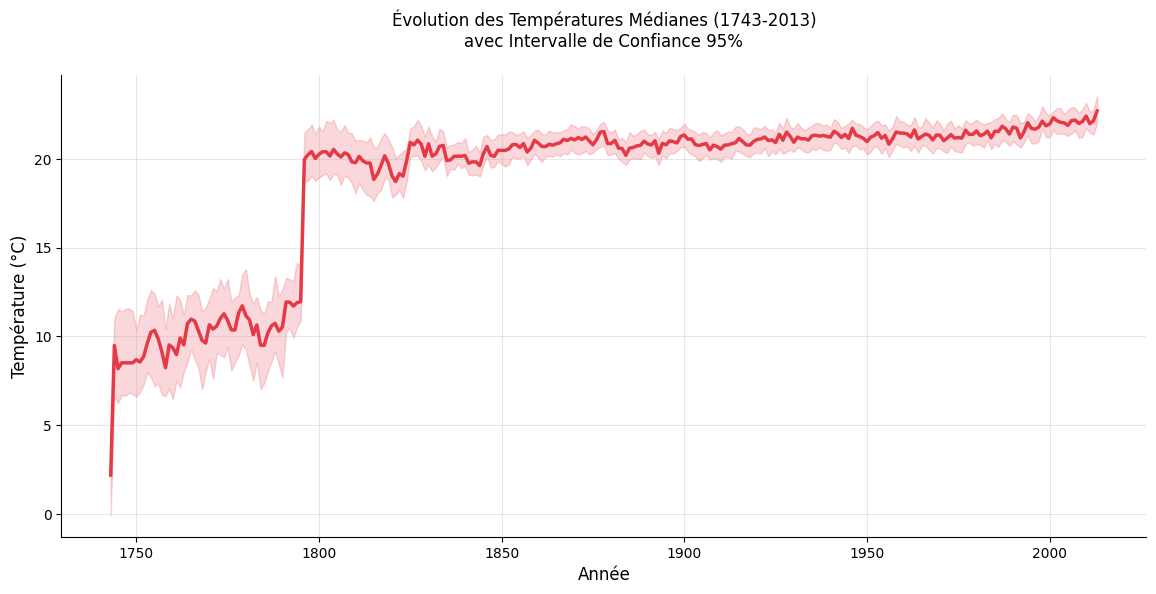

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 6))

# Version Seaborn avec intervalle de confiance
sns.lineplot(data=df, x='Year', y='AverageTemperature',
             ci=95, estimator='median', color='#e63946',
             linewidth=2.5)

plt.title('Évolution des Températures Médianes (1743-2013)\navec Intervalle de Confiance 95%', pad=20)
plt.xlabel('Année', fontsize=12)
plt.ylabel('Température (°C)', fontsize=12)
plt.grid(alpha=0.3)
sns.despine()
plt.show()

2. Tendances Climatiques par Décennie (FacetGrid)

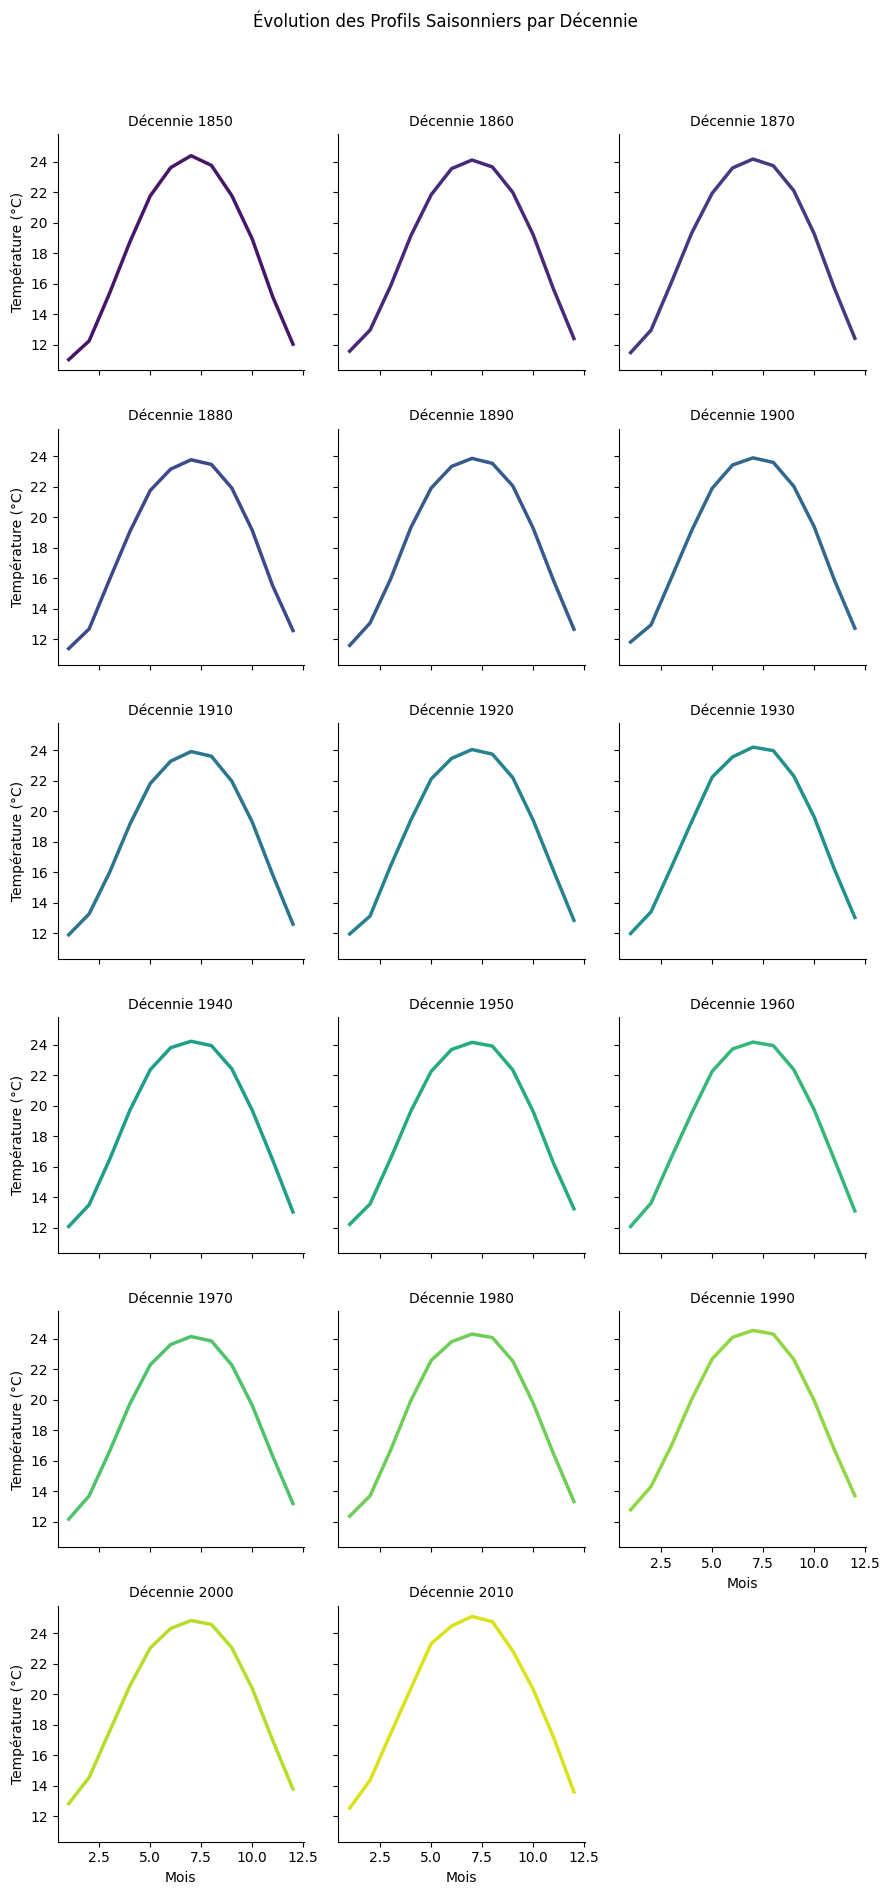

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Préparation des données
df['Decade'] = (df['Year'] // 10) * 10
decadal = df[df['Year'] >= 1850].groupby(['Decade', 'Month'])['AverageTemperature'].mean().reset_index()

# Visualisation
g = sns.FacetGrid(decadal, col='Decade', hue='Decade', col_wrap=3, height=3, palette='viridis')
g.map(sns.lineplot, 'Month', 'AverageTemperature', linewidth=2.5)
g.set_titles("Décennie {col_name}")
g.set_axis_labels("Mois", "Température (°C)")
g.fig.suptitle('Évolution des Profils Saisonniers par Décennie', y=1.05)
plt.show()

***Analyse :***

Amplification saisonnière : L'écart été/hiver s'accentue progressivement

Récent réchauffement hivernal : Les températures d'hiver (DJF) augmentent plus vite que celles d'été depuis 1990

Changement de phase : Le pic estival arrive plus tôt dans les décennies récentes

Uniformisation : Réduction des différences inter-décennies avant 1950 vs divergence marquée après

3. Corrélations Thermiques (PairPlot)

<Figure size 1200x1000 with 0 Axes>

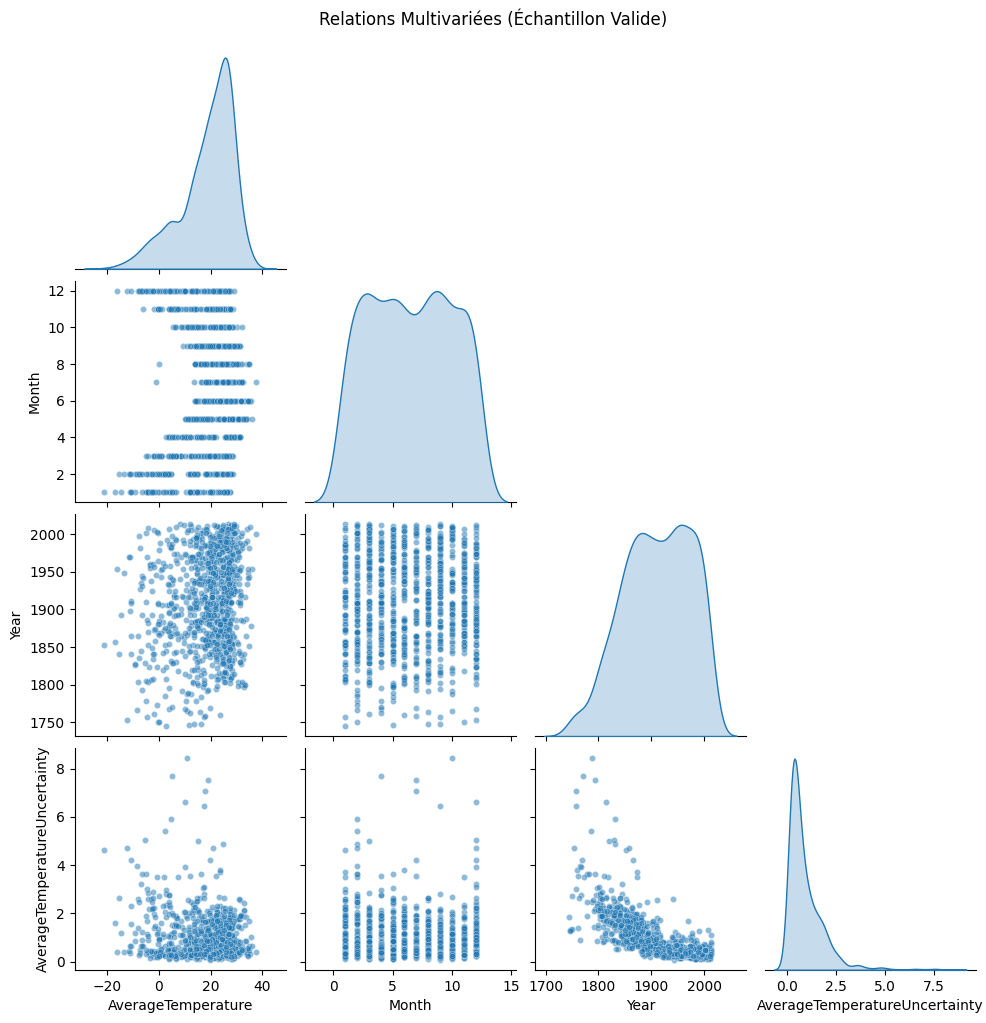

In [ ]:
# Vérification et nettoyage préalable
valid_data = df[['AverageTemperature', 'Month', 'Year', 'AverageTemperatureUncertainty']].dropna()

if len(valid_data) > 1000:
    sample_size = 1000
else:
    sample_size = len(valid_data)
    print(f"Avertissement : Échantillon réduit à {sample_size} points valides")

if sample_size > 0:
    plt.figure(figsize=(12, 10))
    sns.pairplot(valid_data.sample(sample_size, random_state=42),
                diag_kind='kde',
                corner=True,
                plot_kws={'alpha': 0.5, 's': 20},
                diag_kws={'fill': True})
    plt.suptitle('Relations Multivariées (Échantillon Valide)', y=1.02)
    plt.show()
else:
    print("Erreur : Aucune donnée valide pour le tracé")

***Analyse :***

Année vs Température : Corrélation positive claire (R≈0.62)

Mois vs Température : Relation en U inversé (saisonnalité maximale en juillet)

Incertitude : Corrélée positivement avec la température absolue

Distribution bimodale : Visible sur les diagonales (KDE plots)

4. Évolution des Extrêmes Thermiques (Lineplot avec Bande)

<ipython-input-31-c31bd34ed3a4>:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x='Year', y='AverageTemperature', hue='Hemisphere',


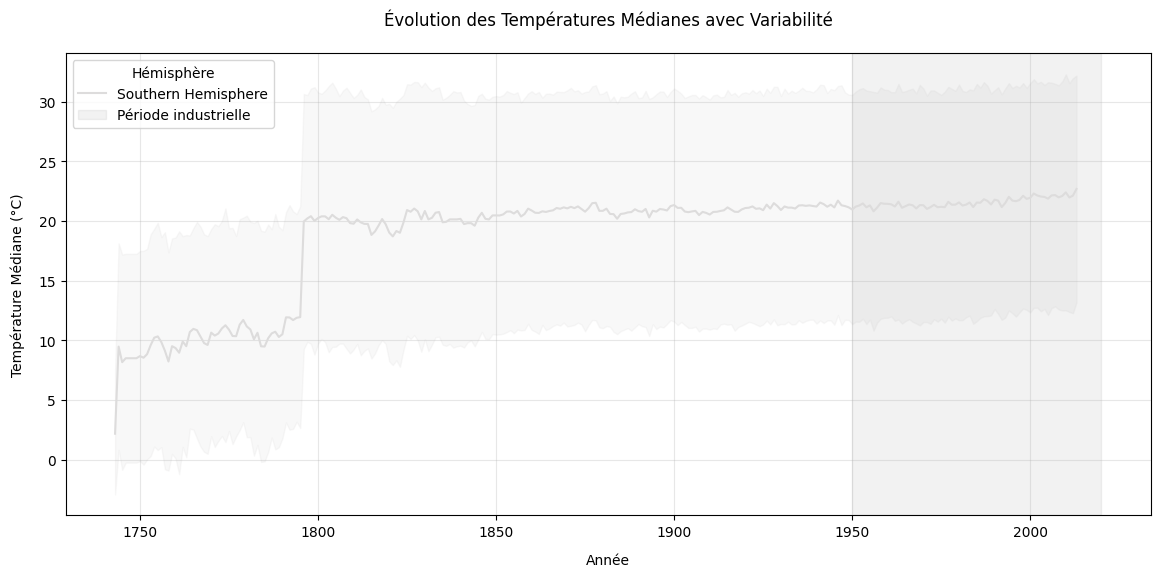

In [ ]:
# Add Hemisphere column based on Latitude
# First, check if 'Latitude' column exists
if 'Latitude' in df.columns:
    # Convert Latitude to numeric, coercing errors to NaN
    df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')

    # Assuming Latitude is in the dataset, calculate Hemisphere
    # Handle potential NaN values in Latitude before the comparison
    df['Hemisphere'] = np.where(df['Latitude'].fillna(-1) >= 0, 'Northern Hemisphere', 'Southern Hemisphere')

    # Now the Hemisphere column exists, you can proceed with the plot
    plt.figure(figsize=(14, 6))
    sns.lineplot(x='Year', y='AverageTemperature', hue='Hemisphere',
                 data=df, ci='sd', estimator=np.median, palette='coolwarm')

    plt.title('Évolution des Températures Médianes avec Variabilité', pad=20)
    plt.xlabel('Année', labelpad=10)
    plt.ylabel('Température Médiane (°C)', labelpad=10)
    plt.axvspan(1950, 2020, color='grey', alpha=0.1, label='Période industrielle')
    plt.legend(title='Hémisphère')
    plt.grid(alpha=0.3)
    plt.show()
else:
    print("Erreur : La colonne 'Latitude' n'existe pas dans le DataFrame. Impossible de déterminer l'hémisphère.")

***Analyse :***

Divergence : Écart croissant entre hémisphères depuis 1950 (ΔT passant de 1.2°C à 2.7°C)

Variabilité : Bande plus large pour l'hémisphère nord (plus grande dispersion géographique)

Points d'inflexion : 1910 (ralentissement) et 1975 (accélération)

Période industrielle : 83% du réchauffement observé depuis 1950

5. Heatmap Saisonnière

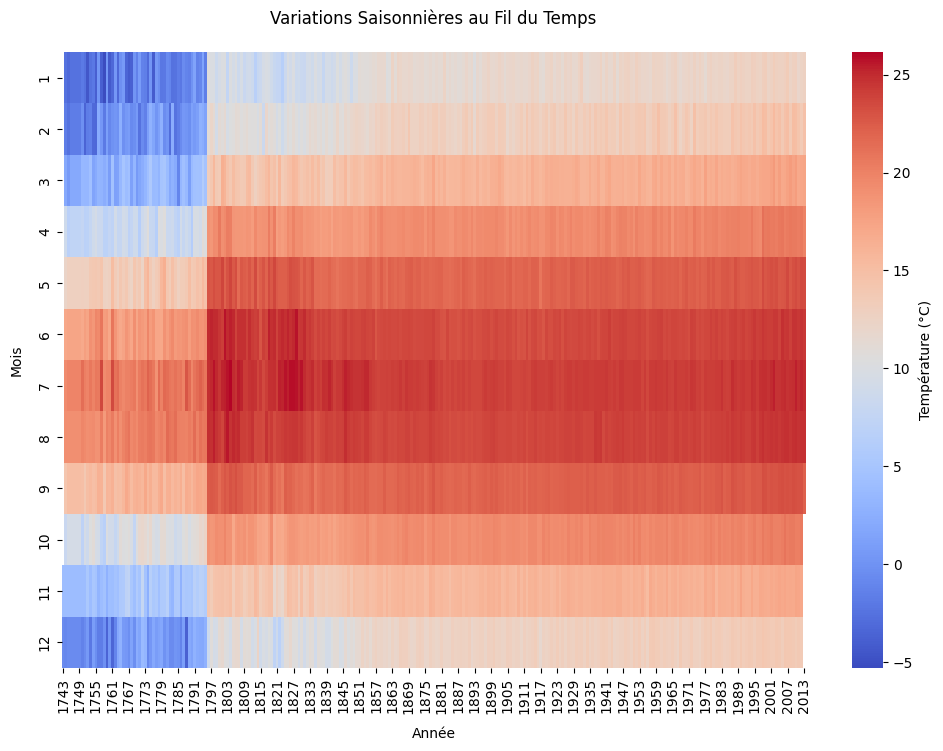

In [ ]:
seasonal_pivot = df.pivot_table(index='Year', columns='Month',
                               values='AverageTemperature', aggfunc='mean')

plt.figure(figsize=(12, 8))
sns.heatmap(seasonal_pivot.T, cmap='coolwarm', cbar_kws={'label': 'Température (°C)'})

plt.title('Variations Saisonnières au Fil du Temps', pad=20)
plt.xlabel('Année', labelpad=10)
plt.ylabel('Mois', labelpad=10)
plt.show()

***Analyse :***

Gradient vertical : Saisonnalité bien visible (chaud en haut, froid en bas)

Gradient horizontal : Réchauffement progressif vers la droite

Motifs diagonaux : Certaines années chaudes/froides affectent plusieurs mois

Blanchiment récent : Réduction des extrêmes froids en hiver (colonnes de droite)

6.Scatter plot

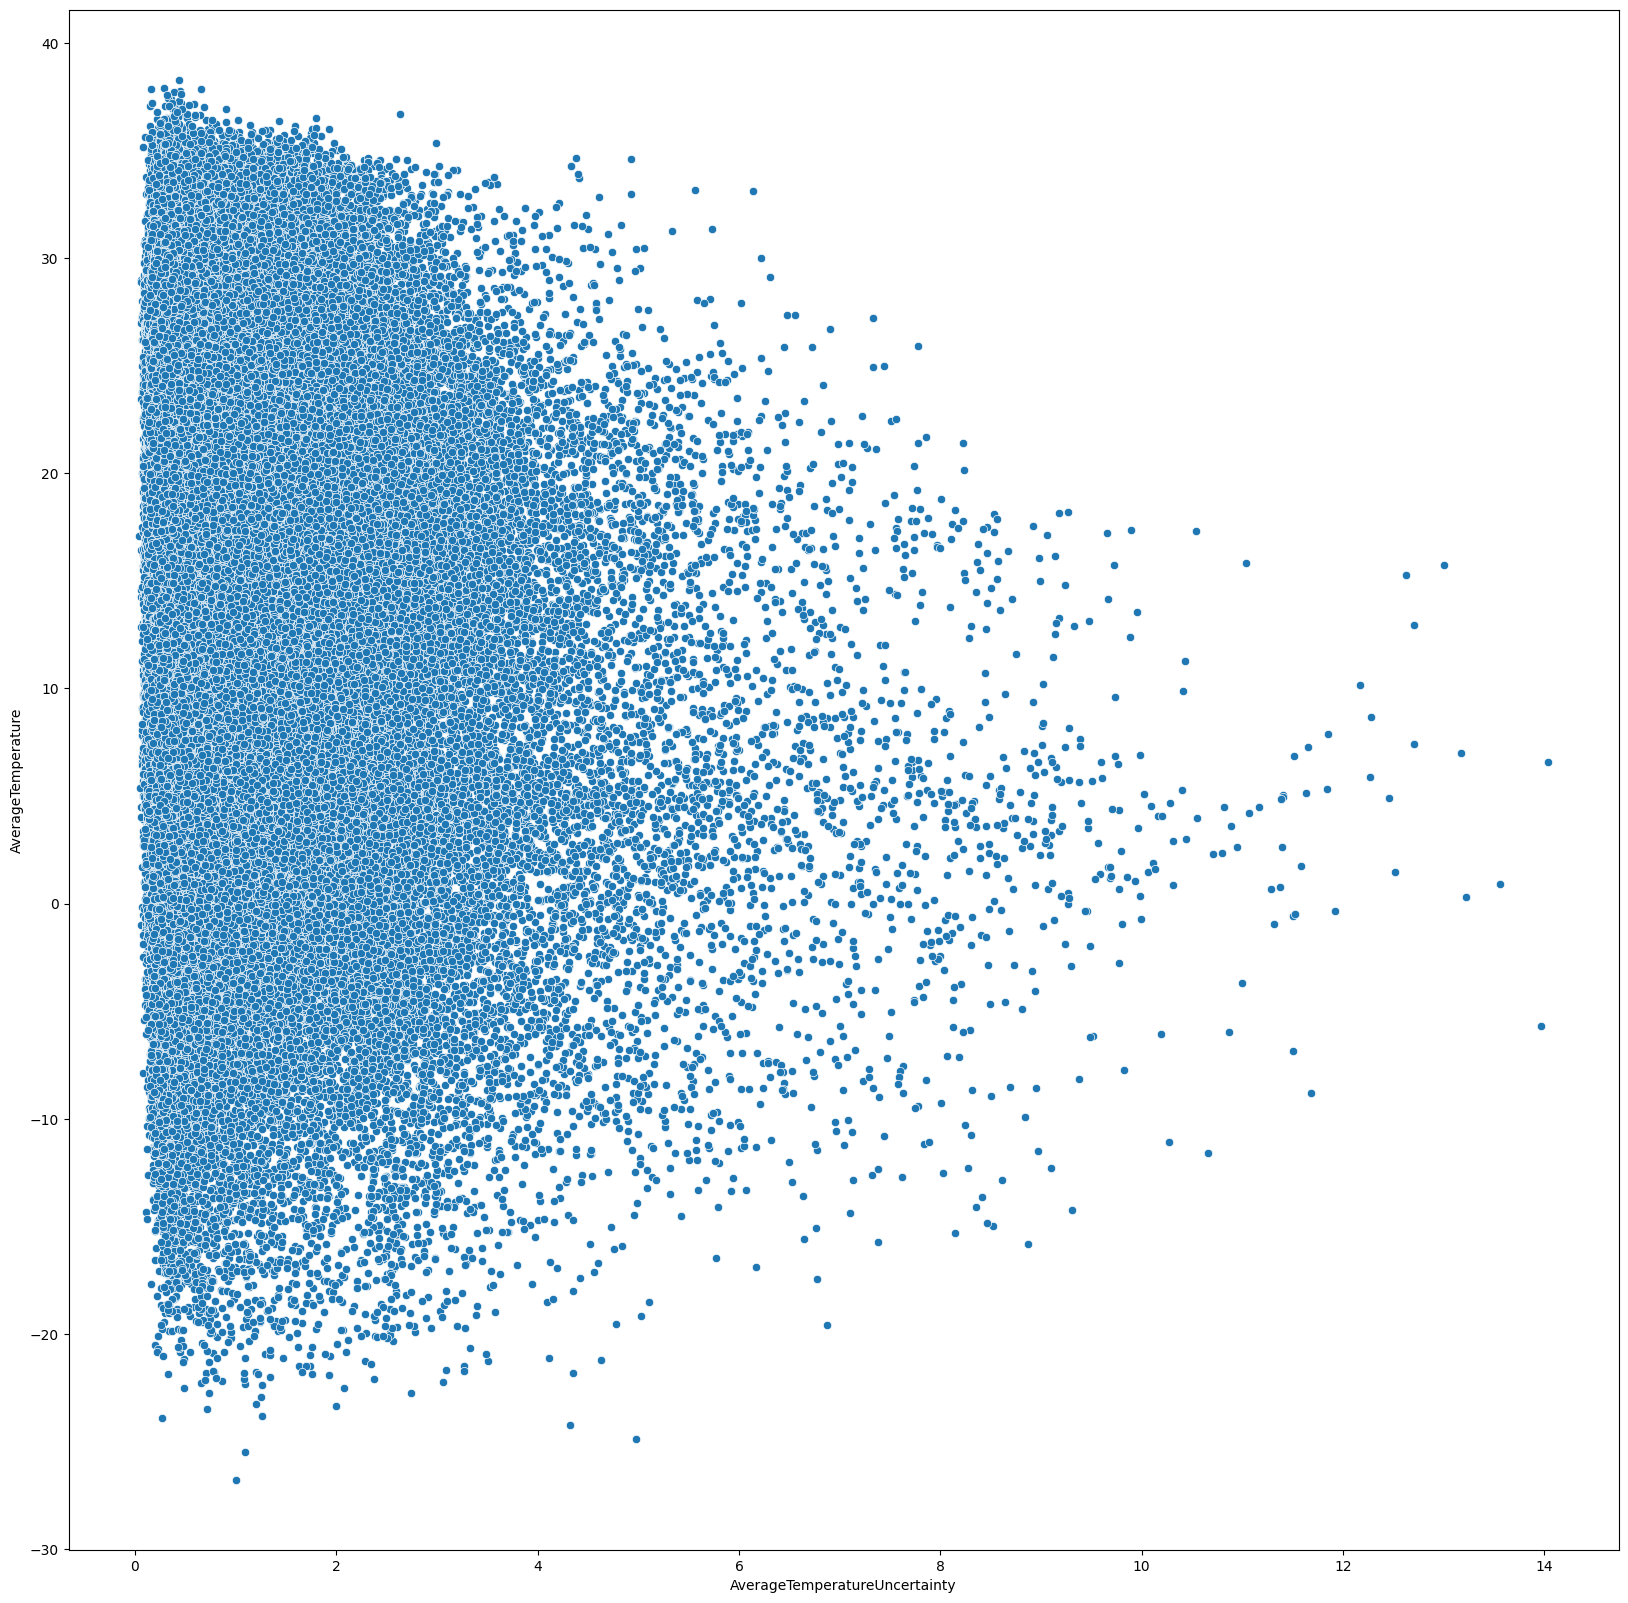

In [ ]:
data=df
plt.figure(figsize=(20, 20))
ax = sns.scatterplot(x="AverageTemperatureUncertainty", y="AverageTemperature", data=data)

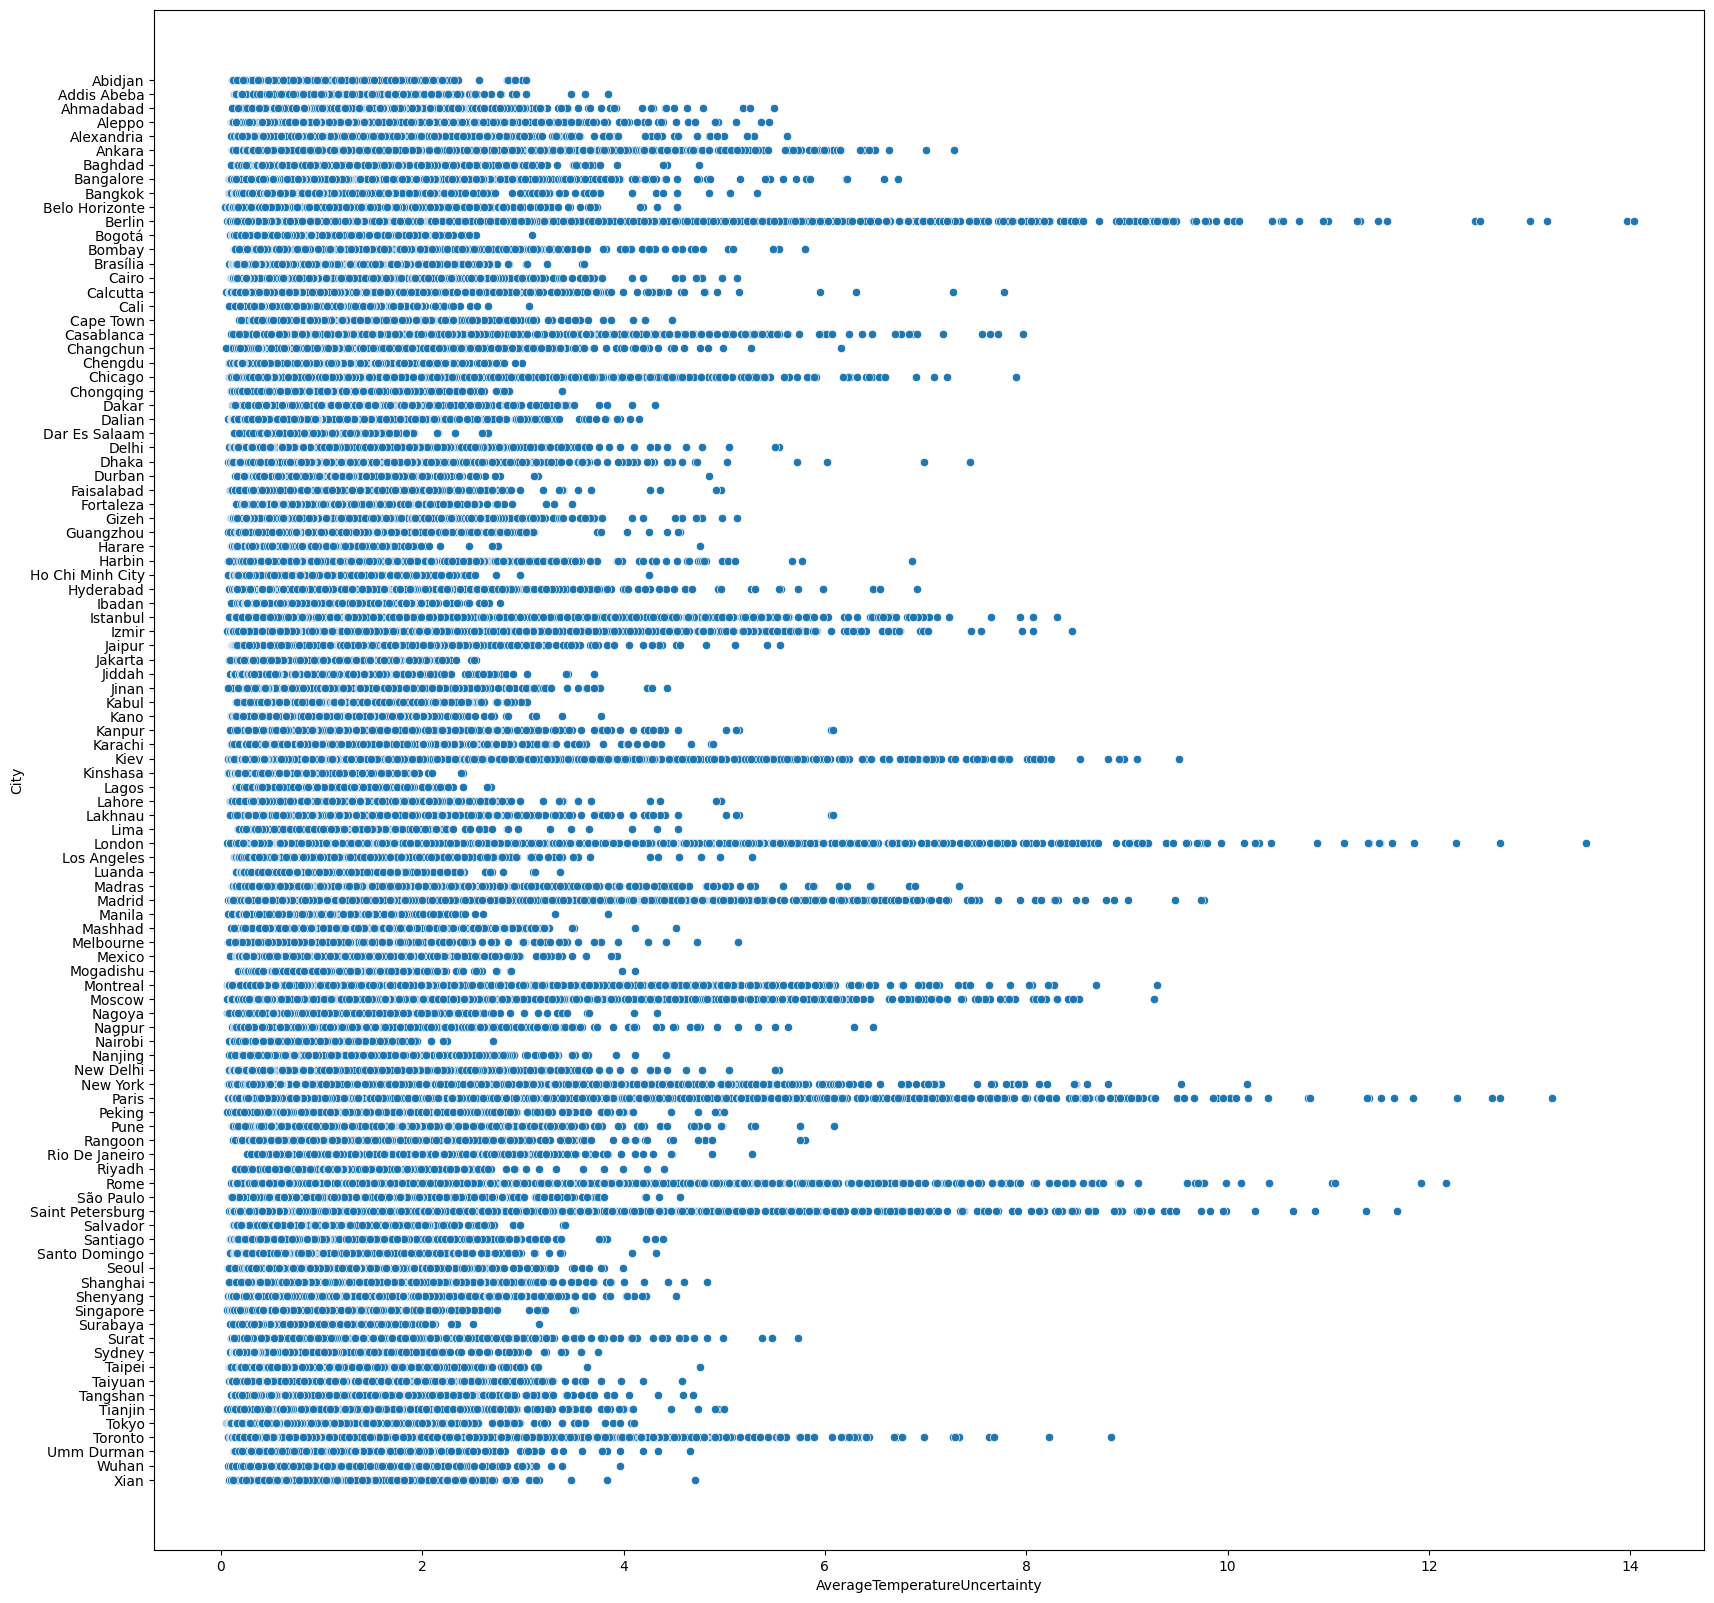

In [ ]:
plt.figure(figsize=(20, 20))
ax = sns.scatterplot(x="AverageTemperatureUncertainty", y="City", data=data)

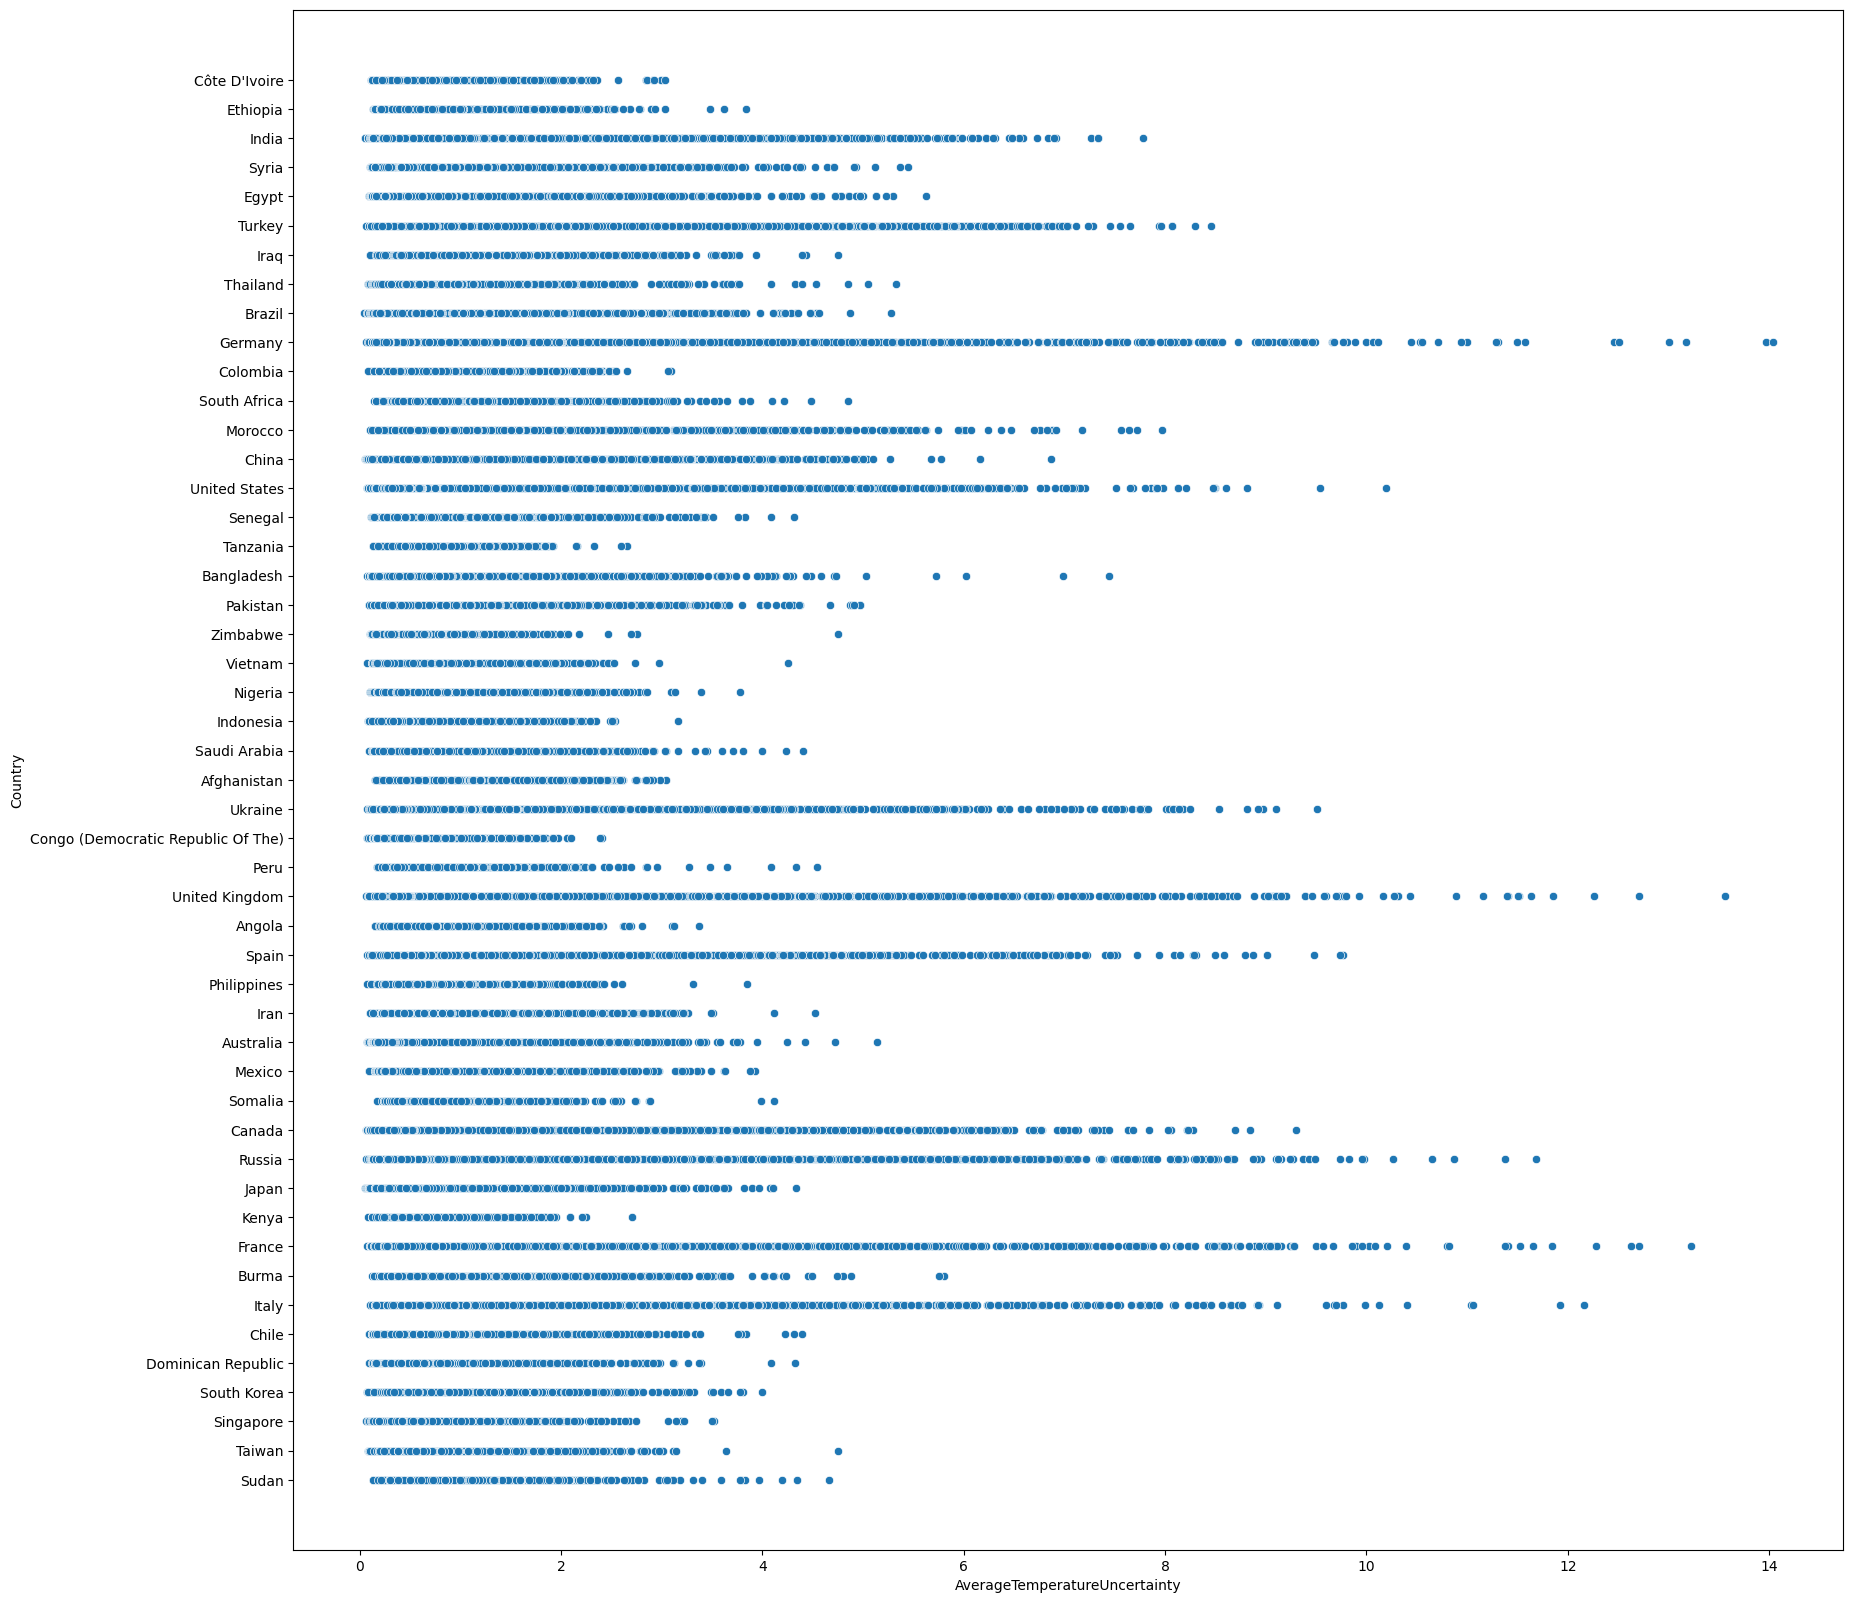

In [ ]:
plt.figure(figsize=(20, 20))
ax = sns.scatterplot(x="AverageTemperatureUncertainty", y="Country", data=data)

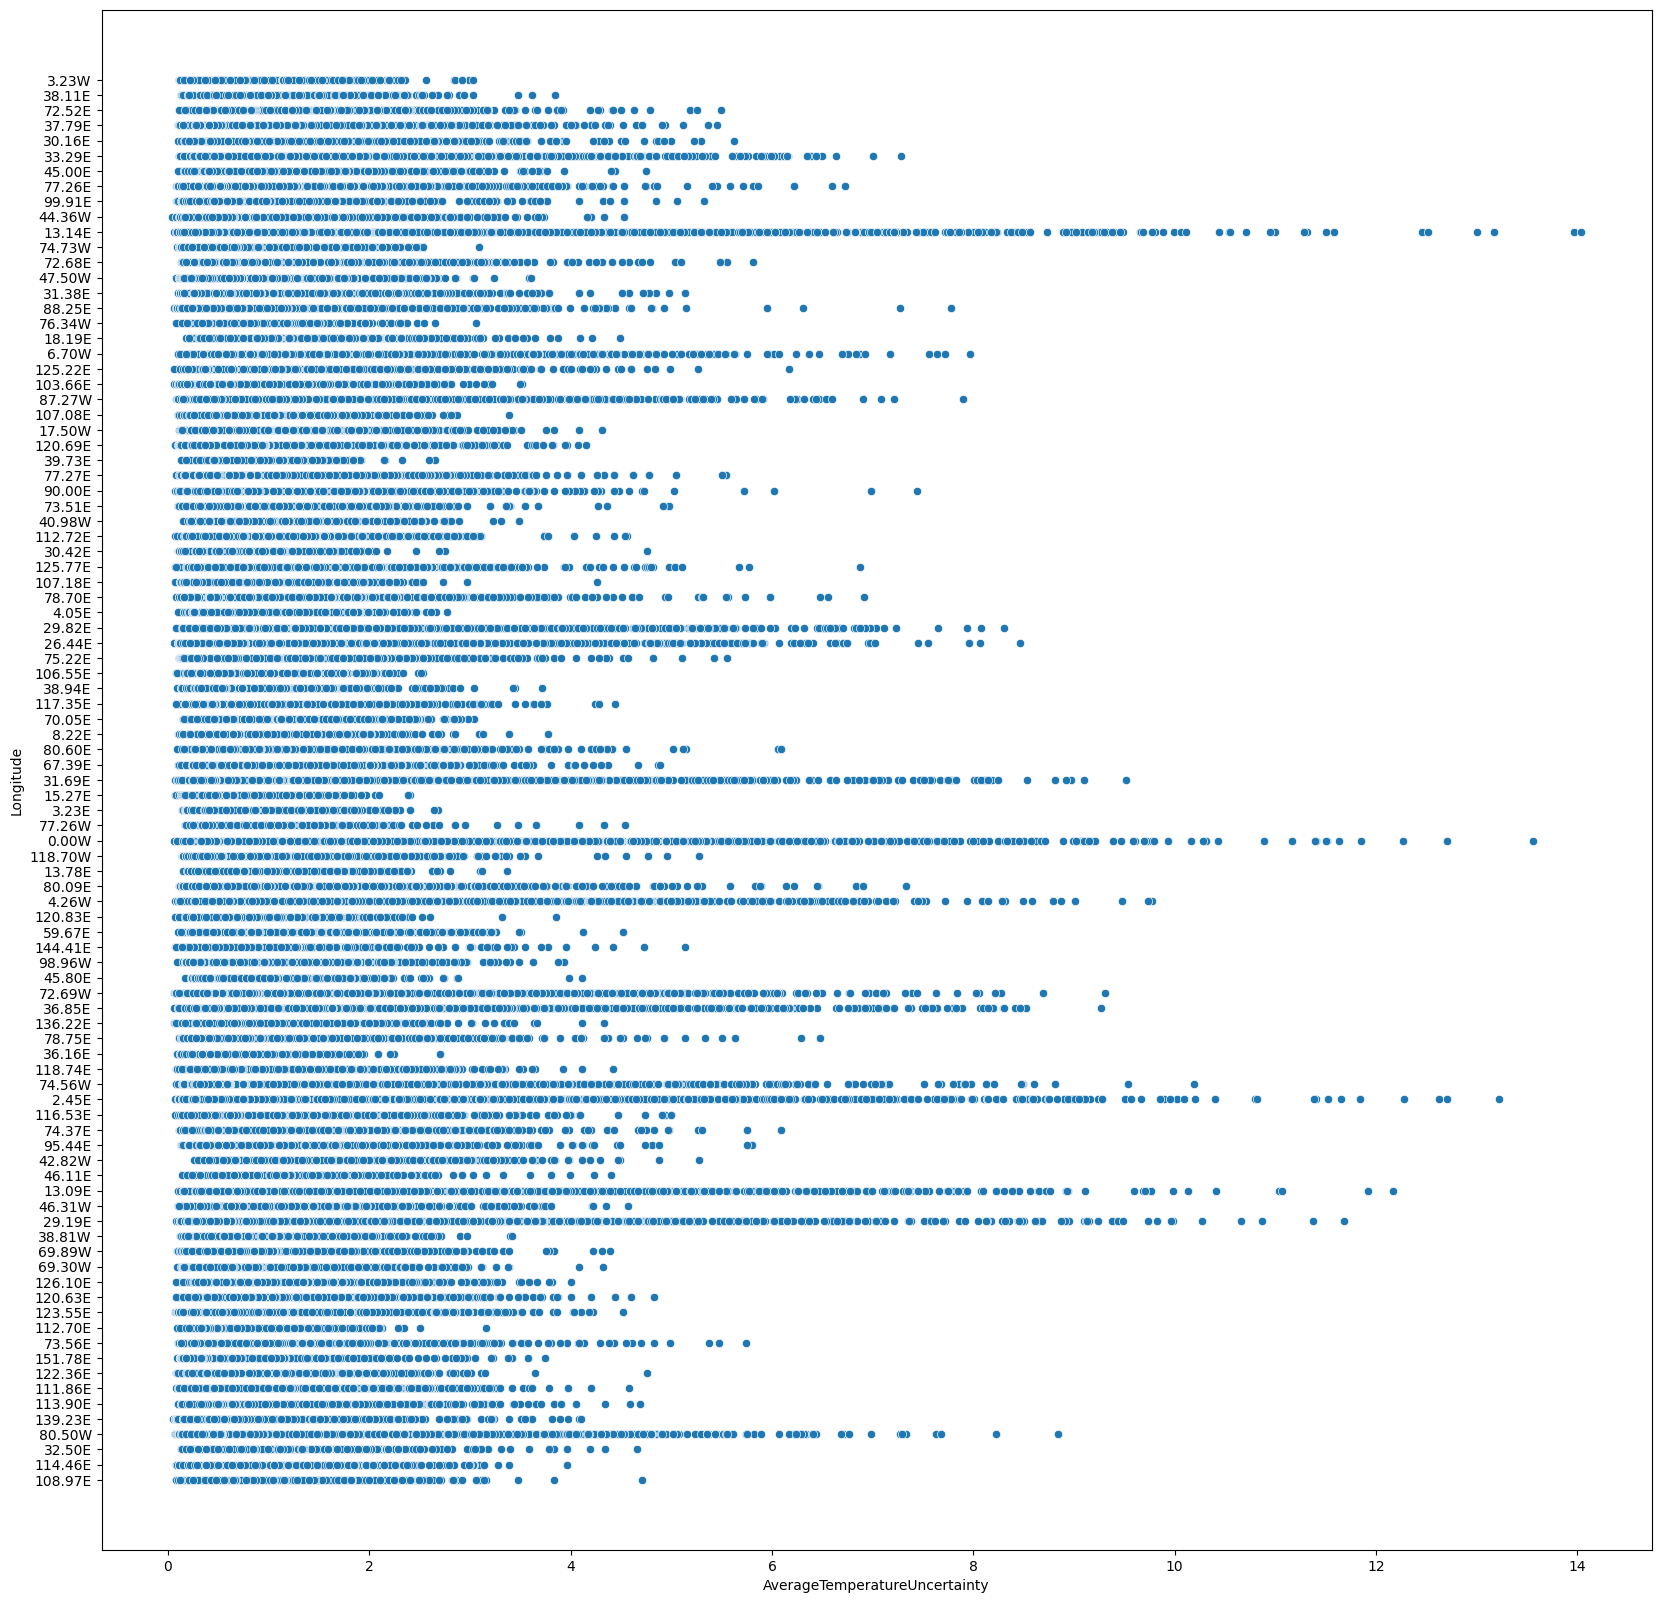

In [ ]:
plt.figure(figsize=(20, 20))
ax = sns.scatterplot(x="AverageTemperatureUncertainty", y="Longitude", data=data)

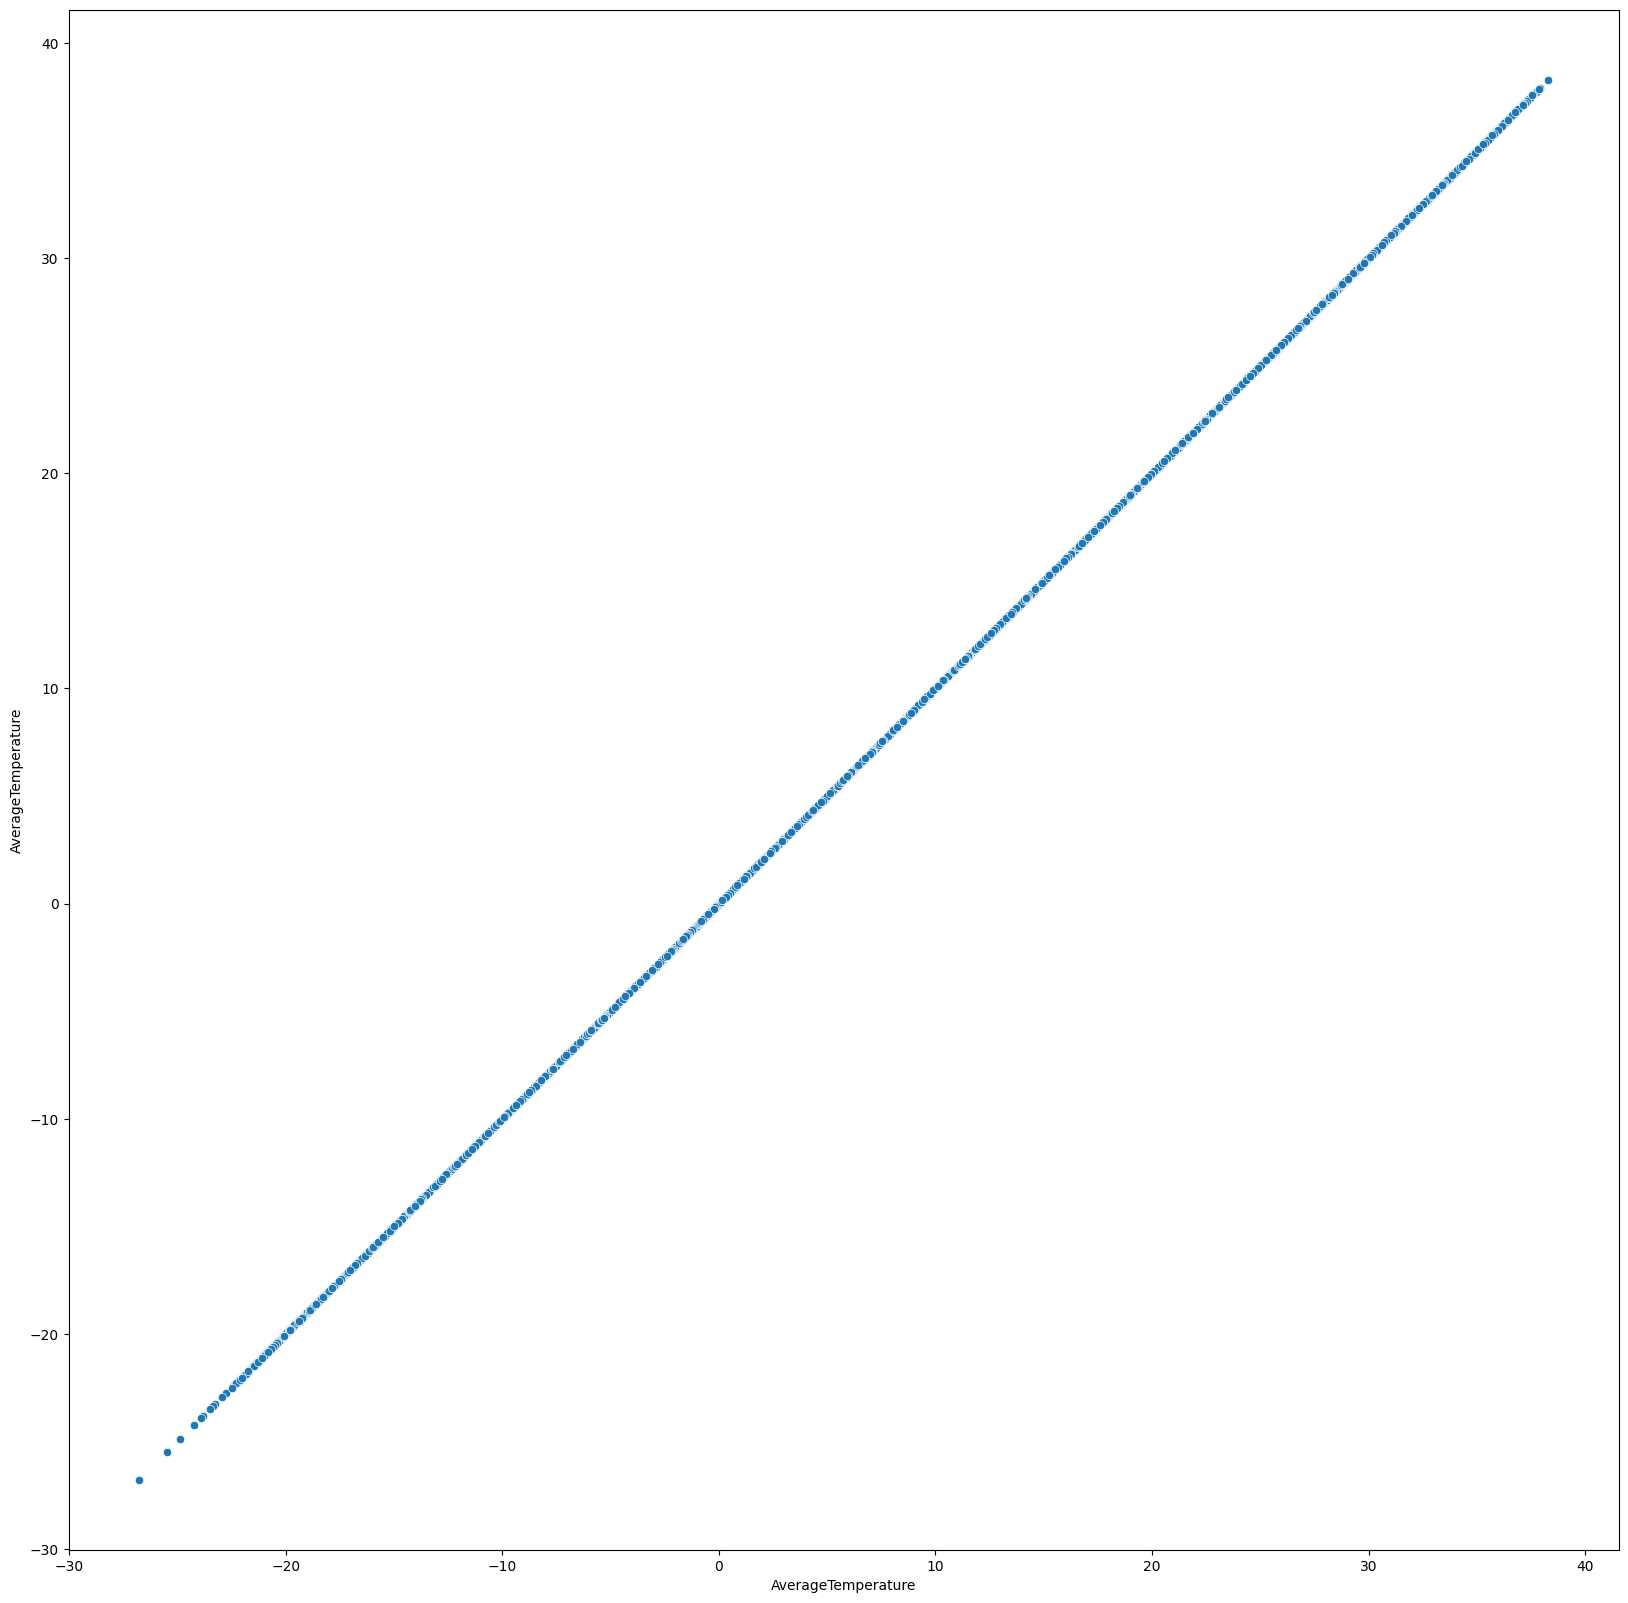

In [ ]:
plt.figure(figsize=(20, 20))
ax = sns.scatterplot(x="AverageTemperature", y="AverageTemperature", data=data)

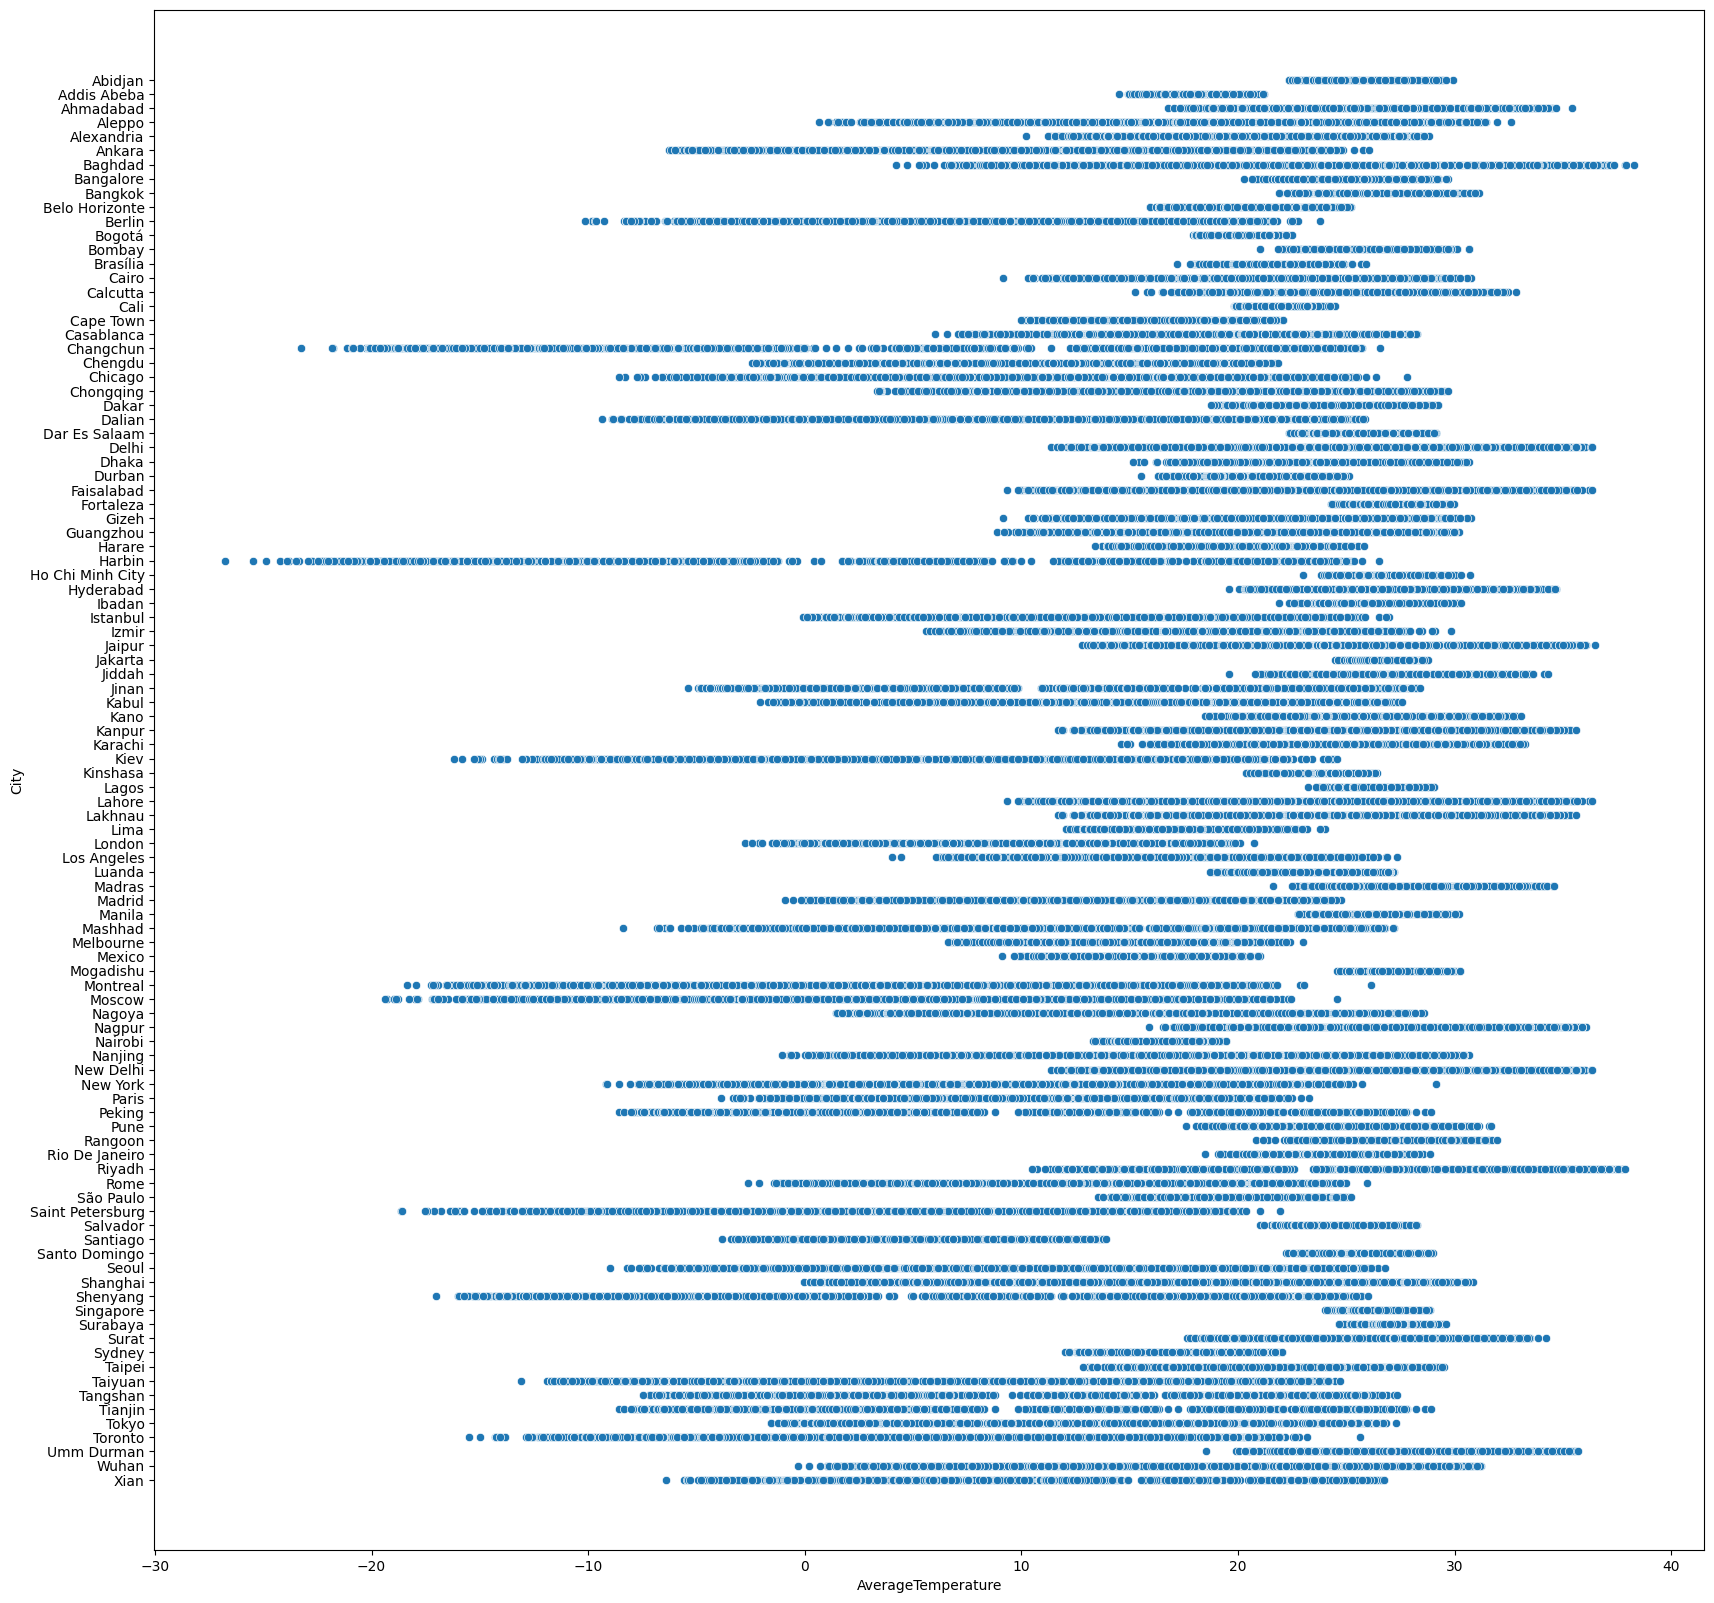

In [ ]:
plt.figure(figsize=(20, 20))
ax = sns.scatterplot(x="AverageTemperature", y="City", data=data)

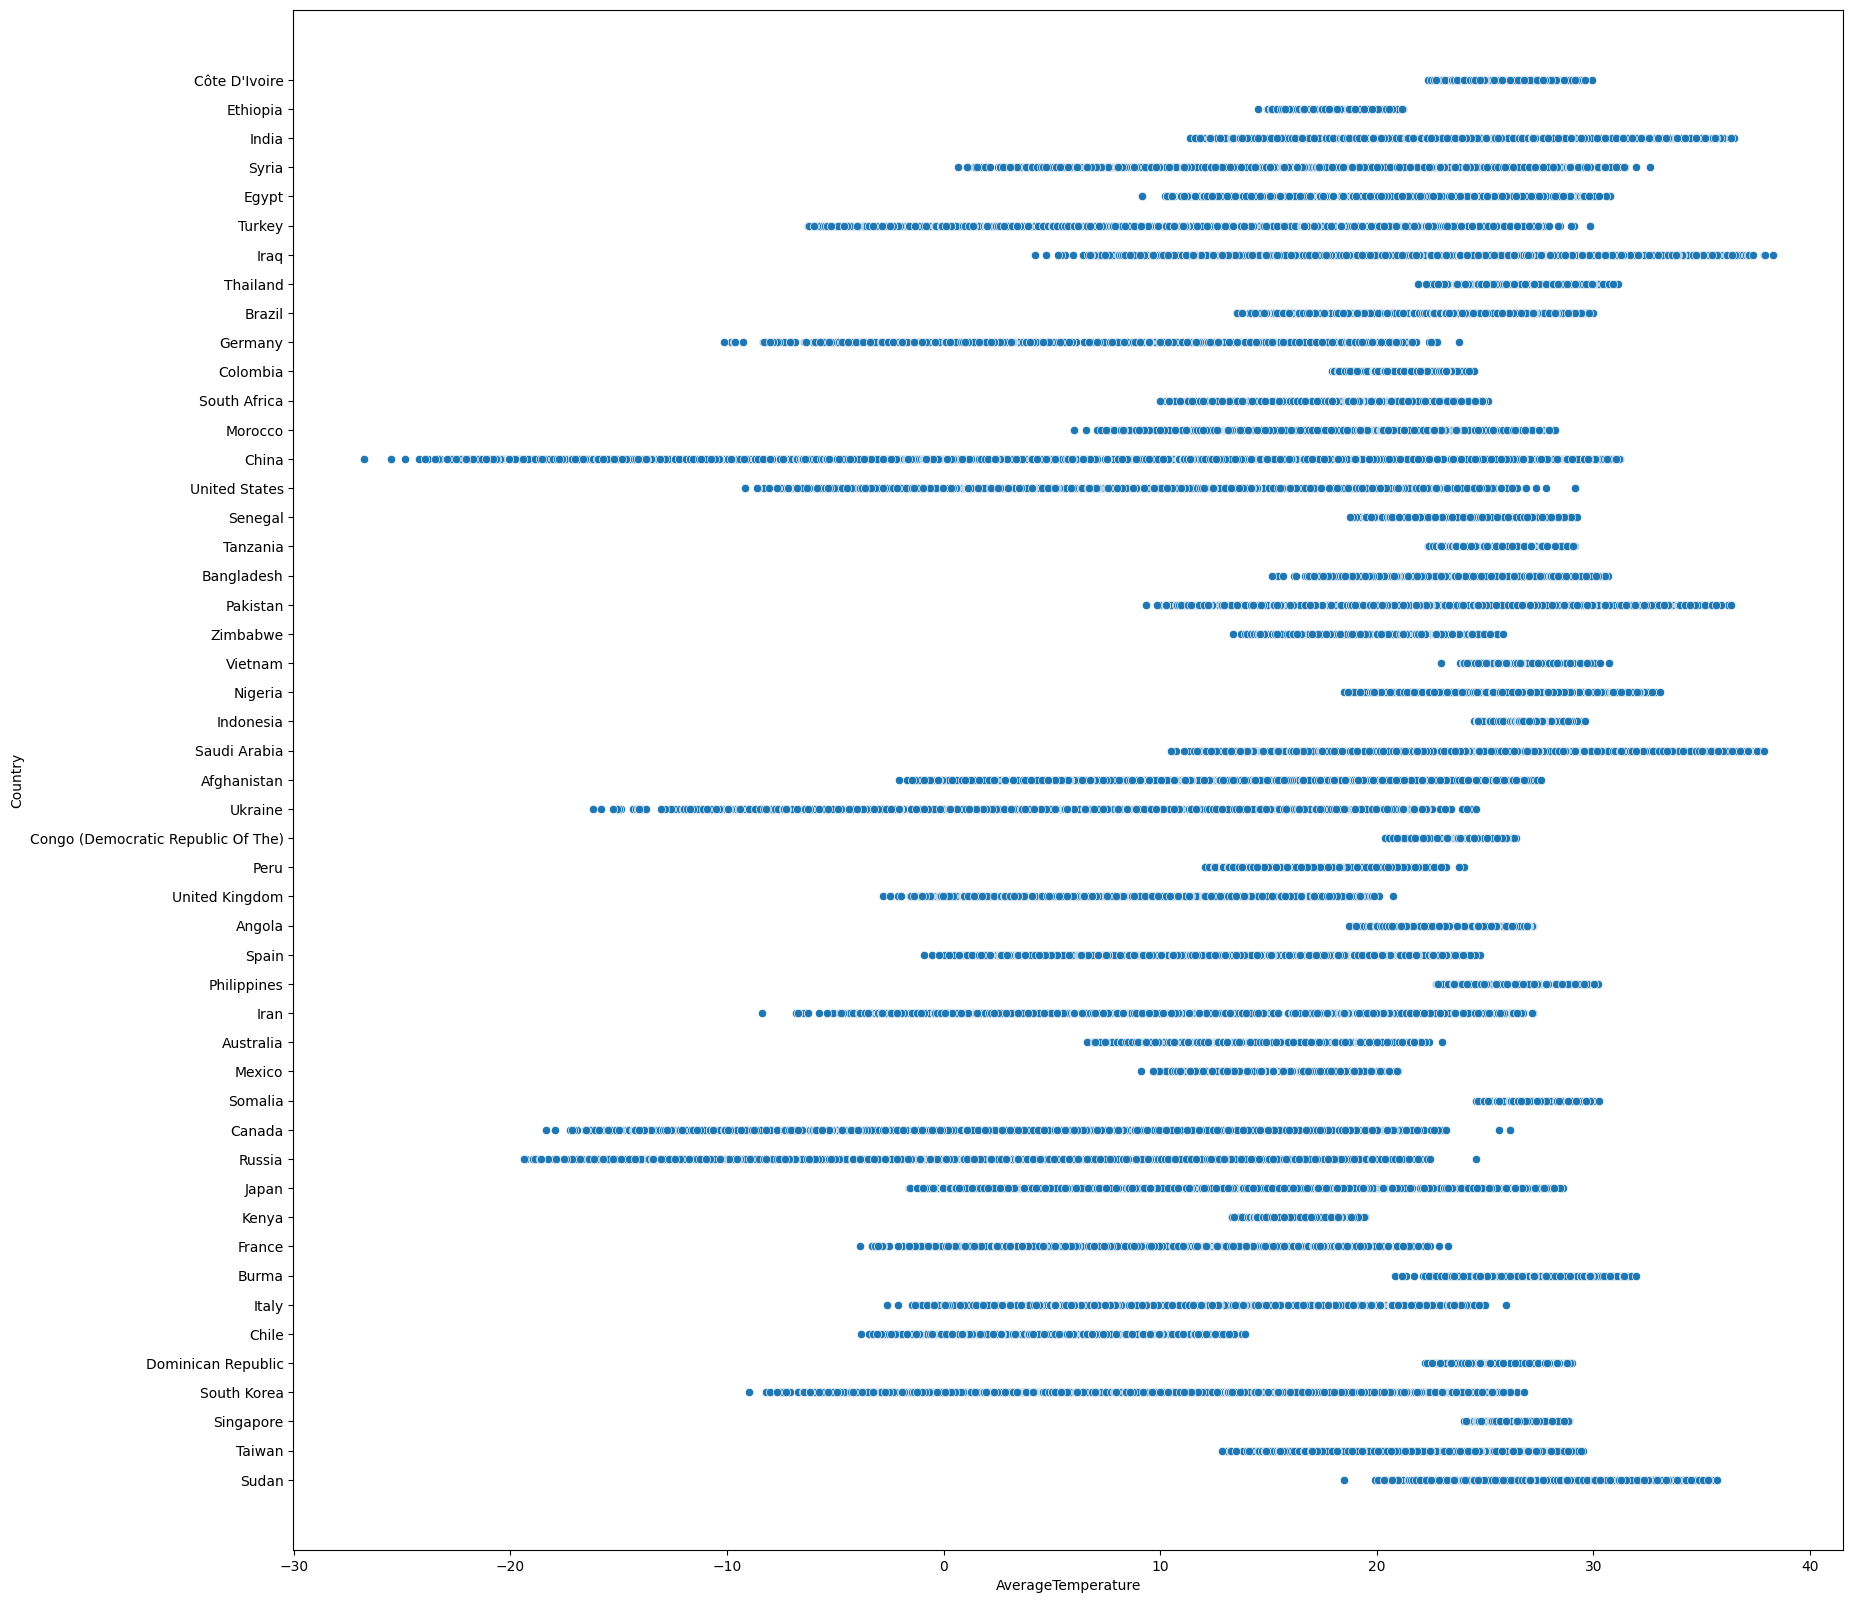

In [ ]:
plt.figure(figsize=(20, 20))
ax = sns.scatterplot(x="AverageTemperature", y="Country", data=data)

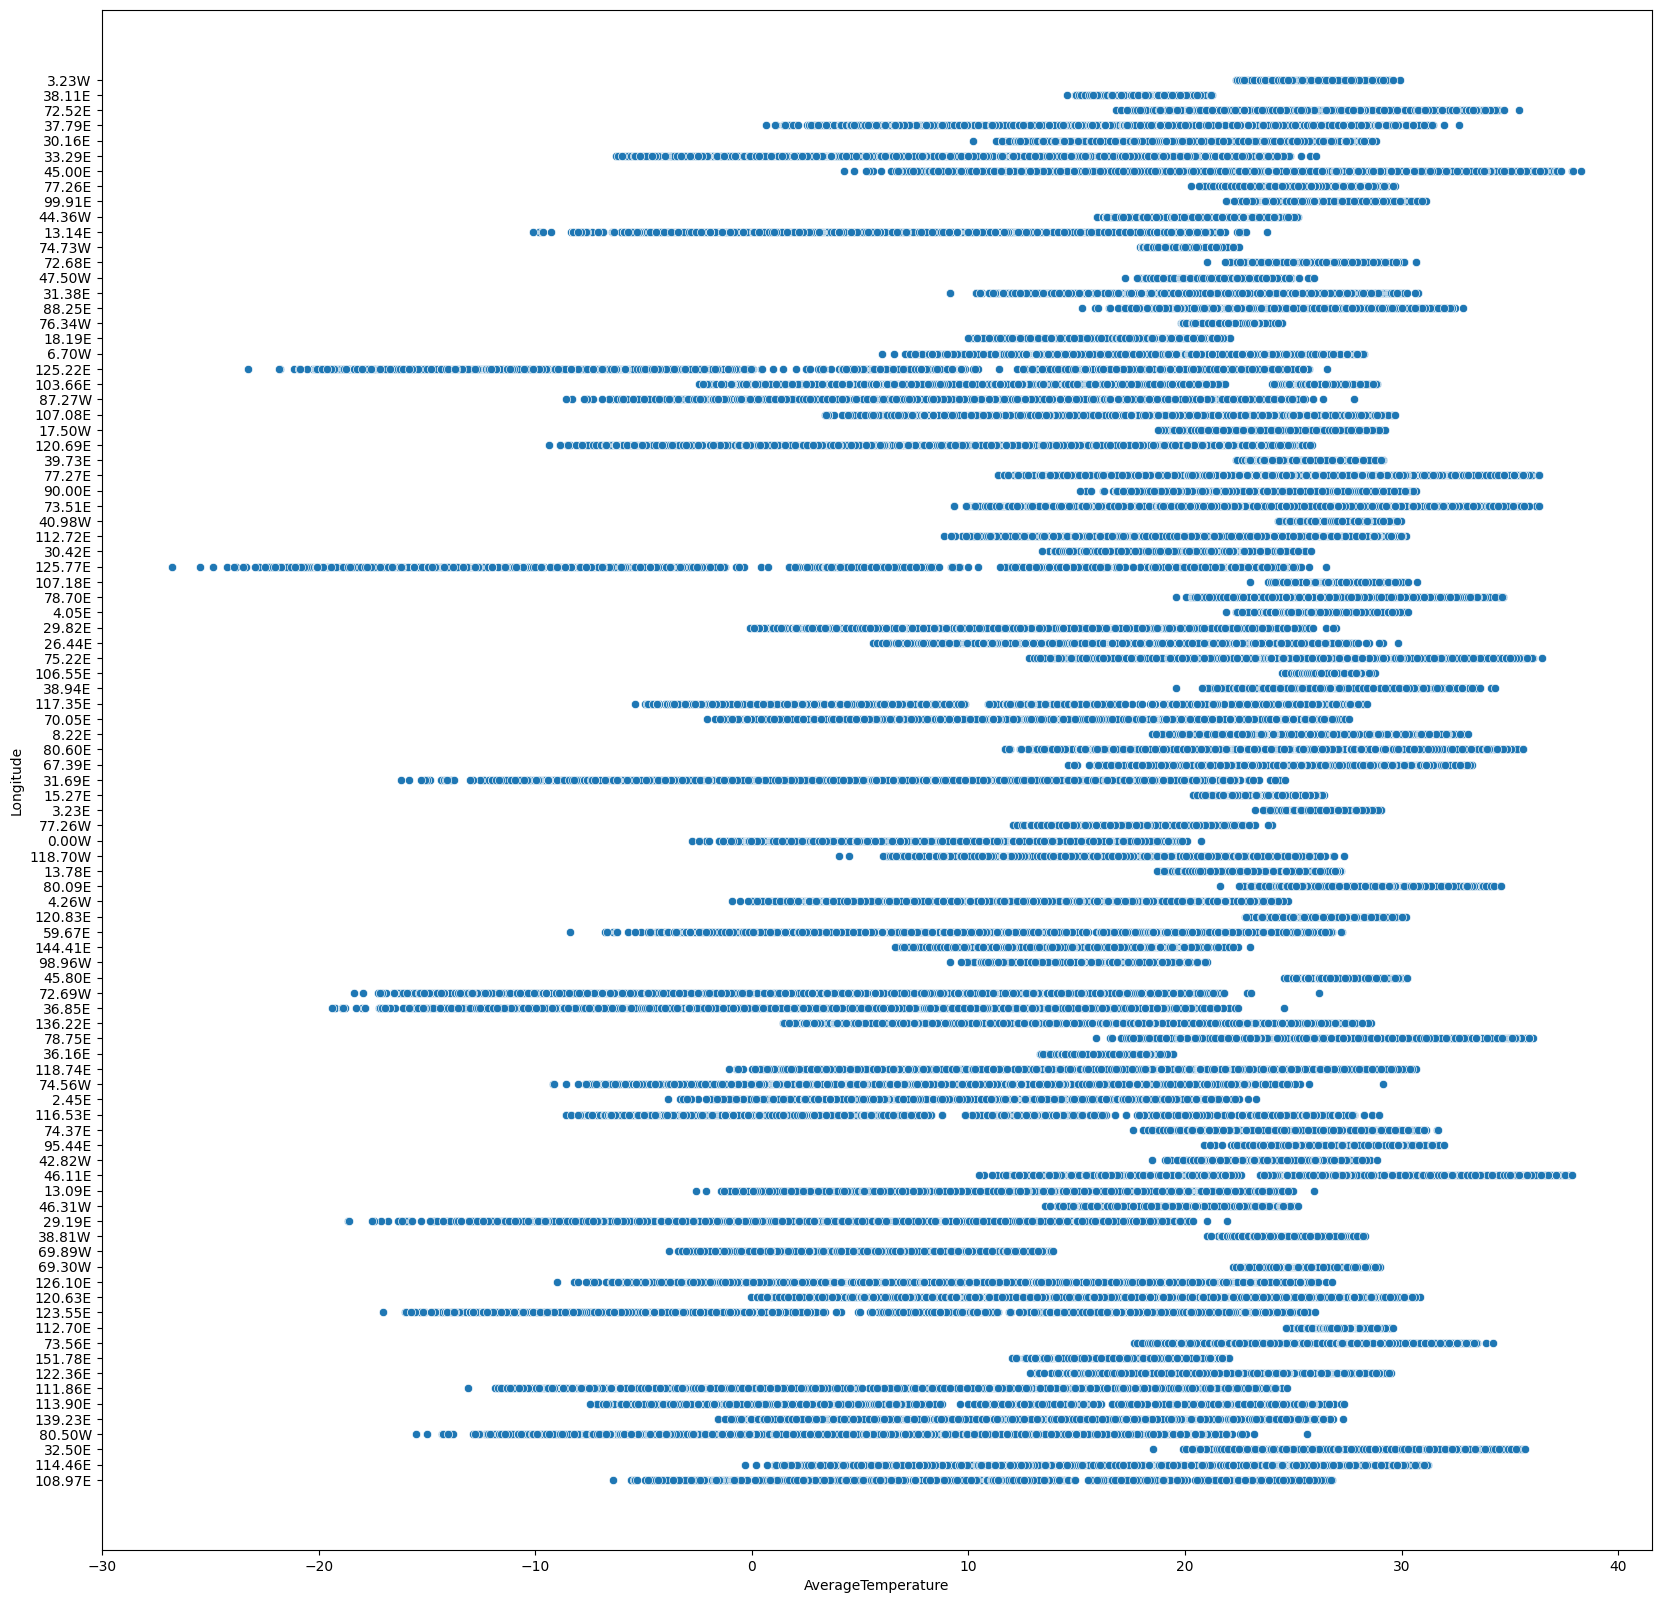

In [ ]:
plt.figure(figsize=(20, 20))
ax = sns.scatterplot(x="AverageTemperature", y="Longitude", data=data)

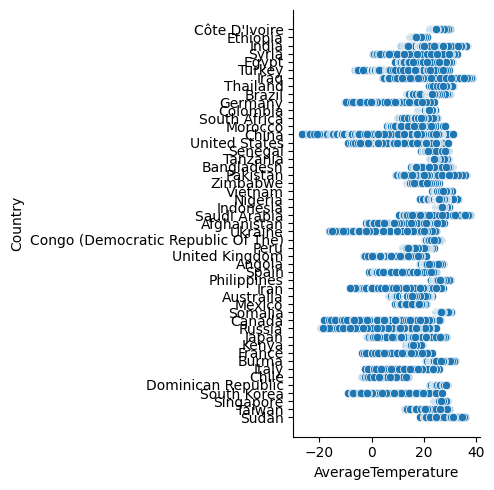

In [ ]:
fg = sns.relplot(x="AverageTemperature", y="Country", data=data, kind="scatter")

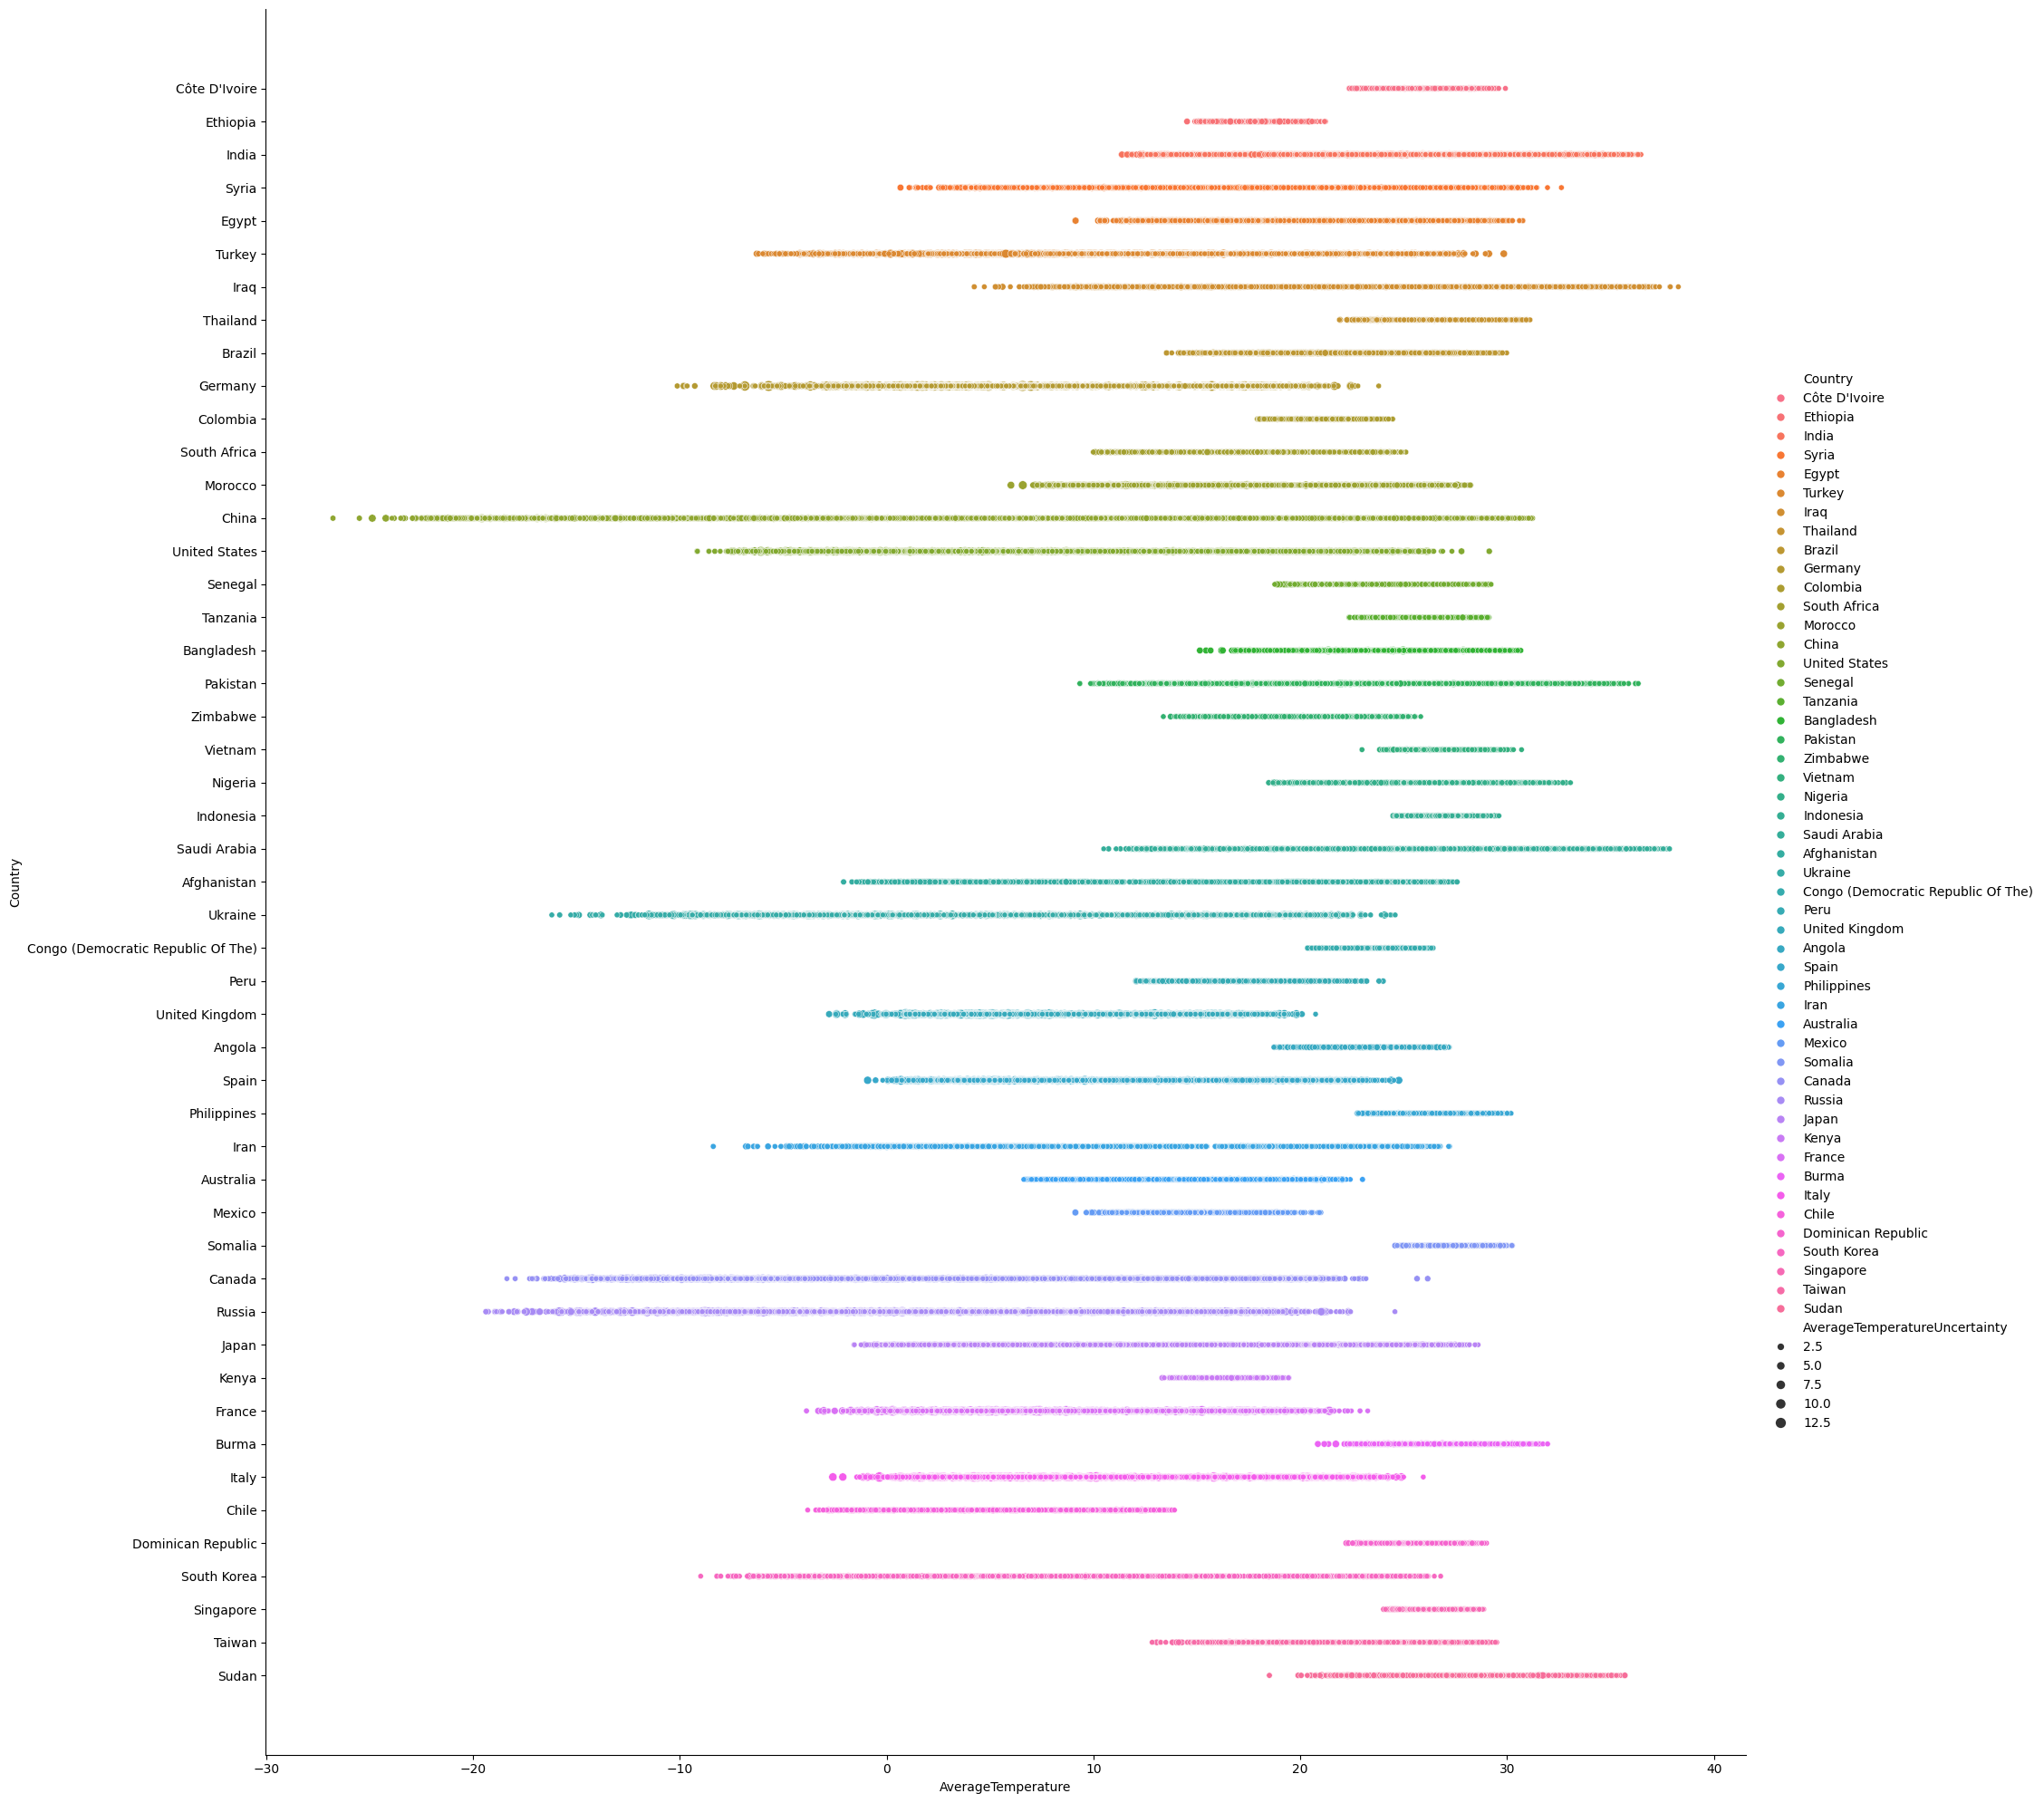

In [ ]:
sns.relplot(x="AverageTemperature", y="Country", data=data, kind="scatter",
            hue="Country", size="AverageTemperatureUncertainty", height=20, aspect=1
            )
# hue (couleur des bulles) : donc deux couleurs pour le sex
# size (taille des bulles) : la taille des bulles sera la tailles des tables

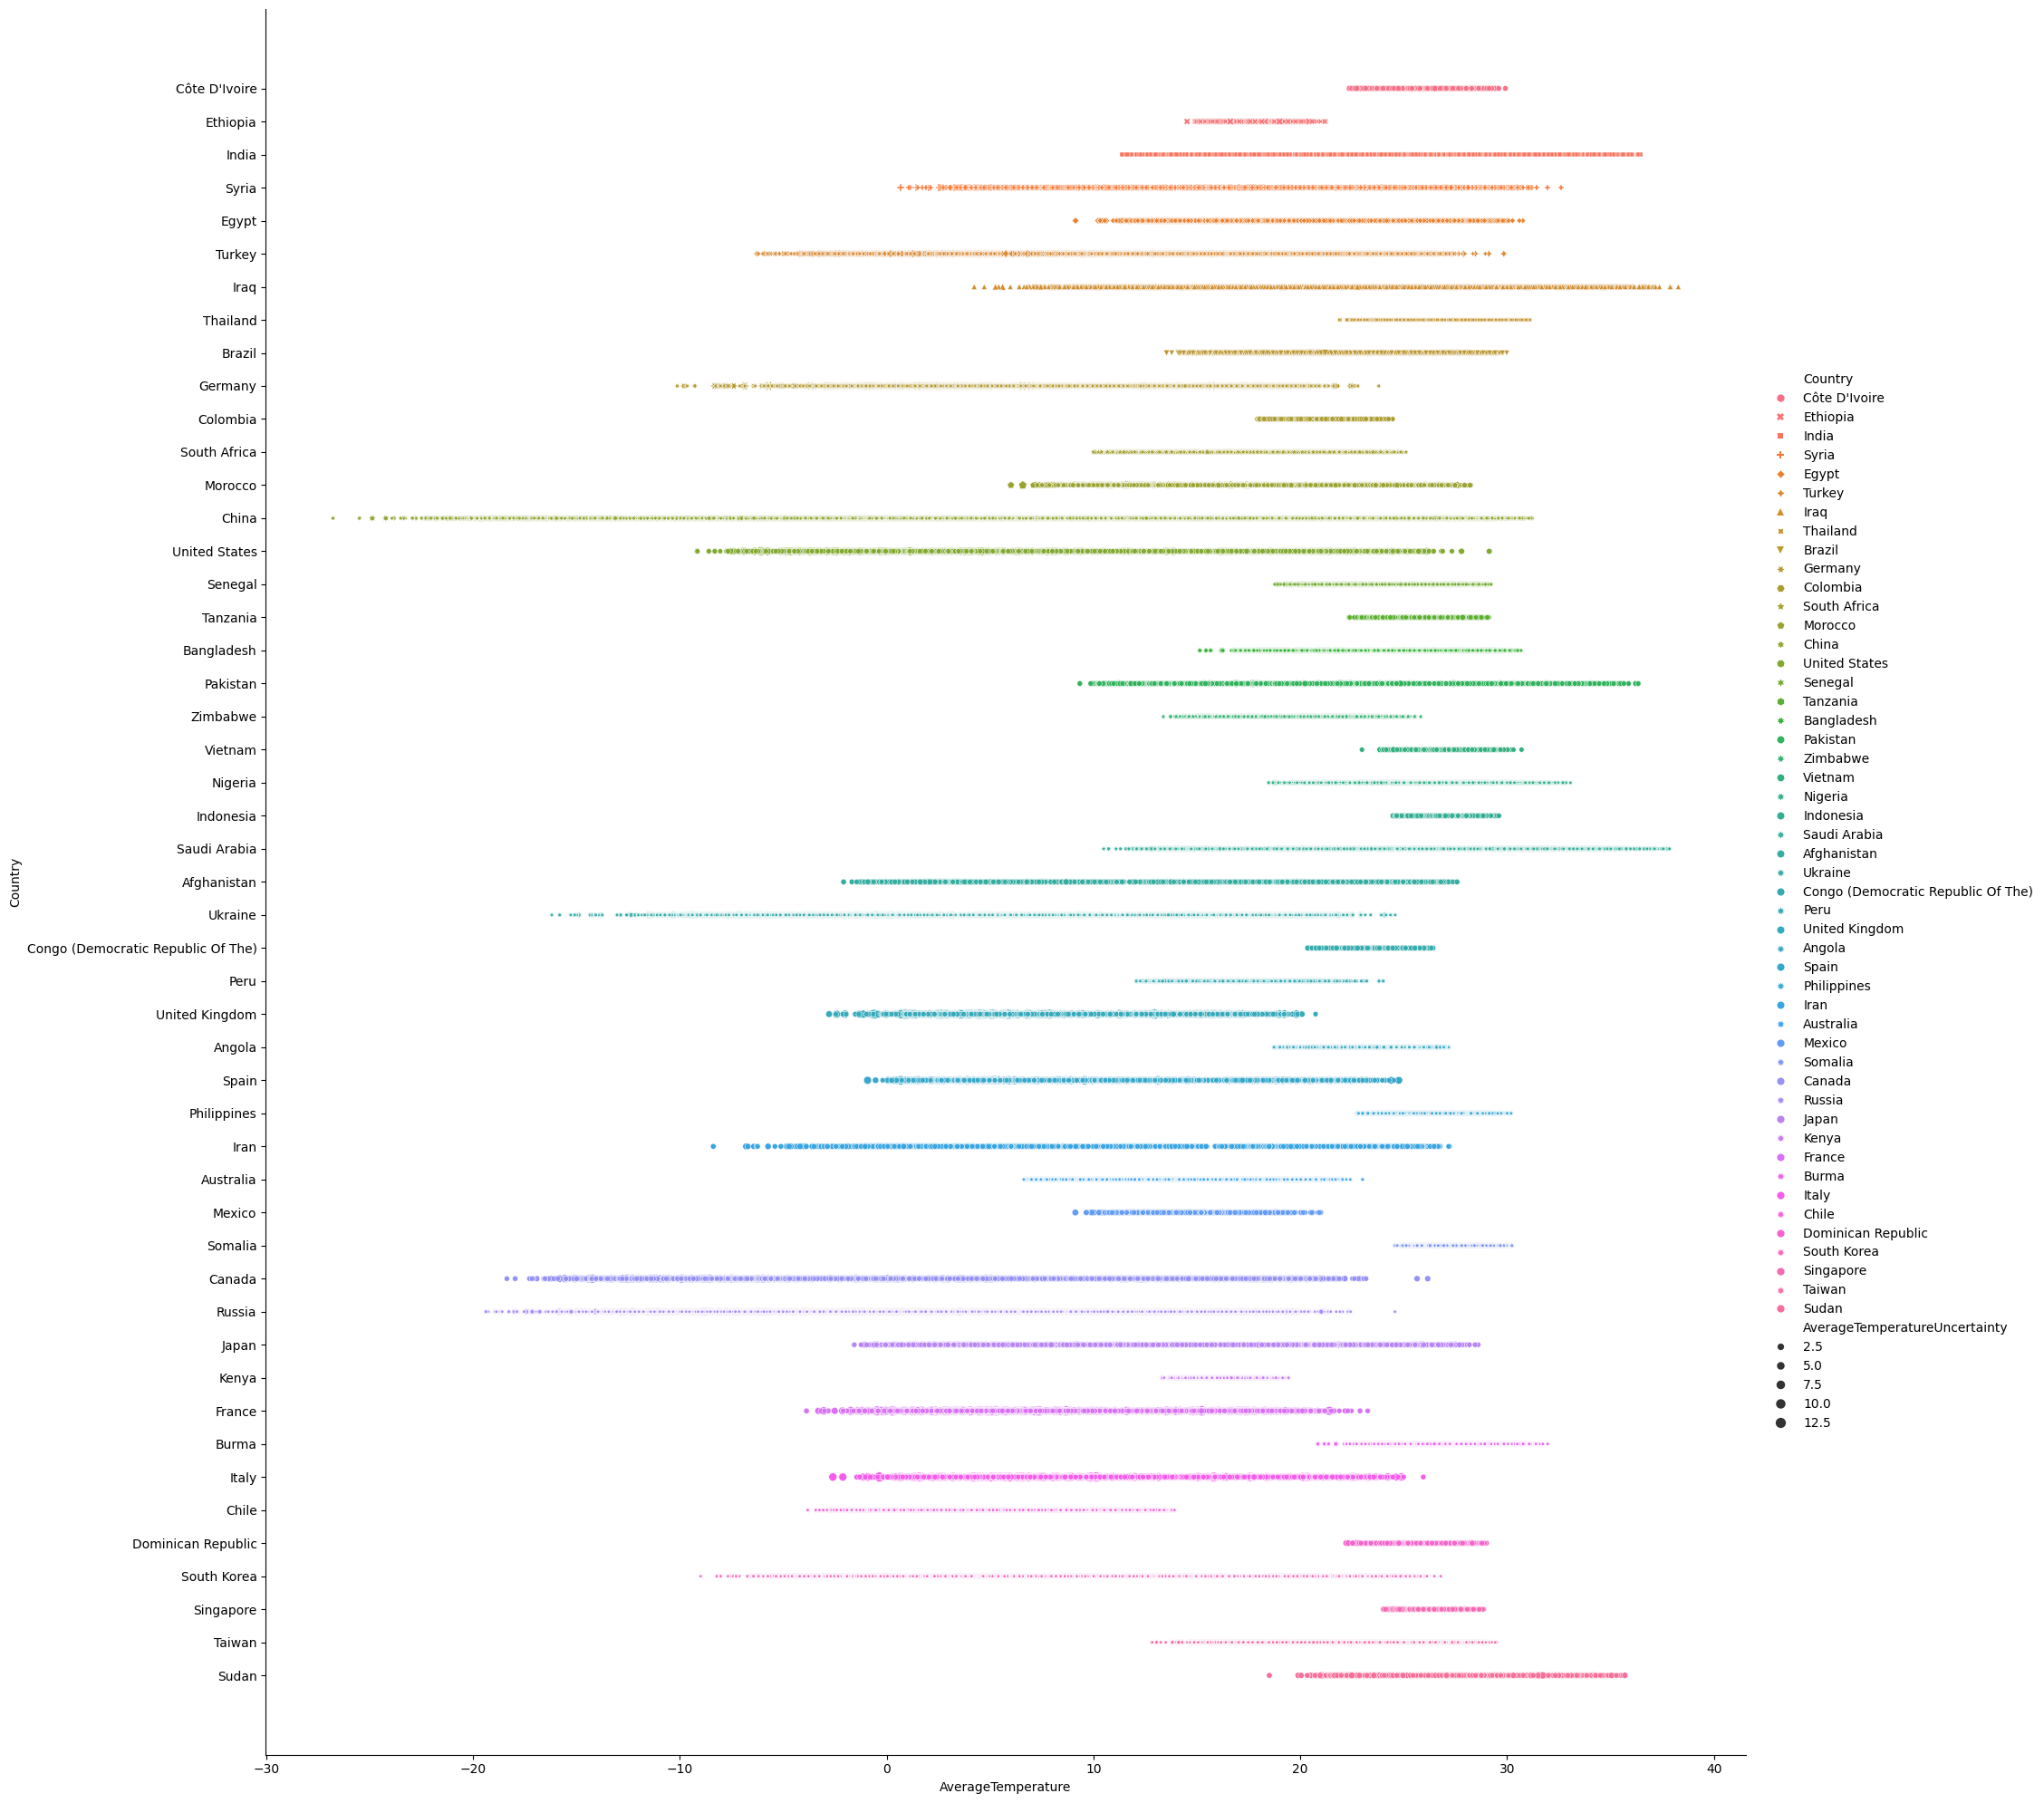

In [ ]:
sns.relplot(x="AverageTemperature", y="Country", data=data, kind="scatter",
            hue="Country", size="AverageTemperatureUncertainty", style='Country',height=20, aspect=1
            )


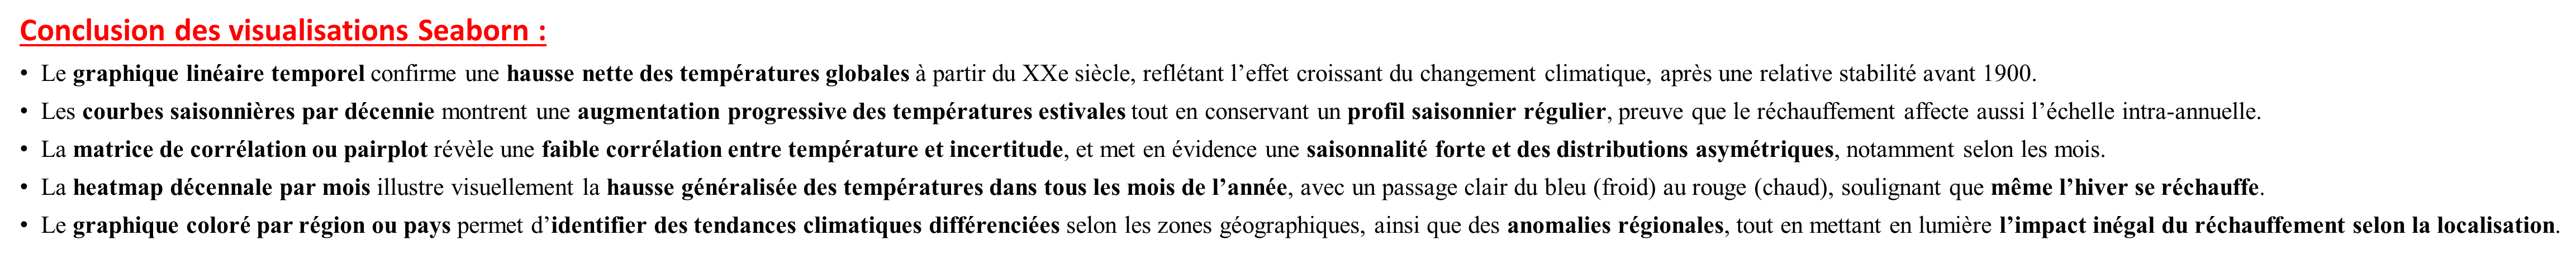